In [32]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from inversion.Strategies.SeismDiffInversion1D import inverse
from inversion.optimizators.optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient, AxOptimizer
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [33]:
from Visualization.Seismic import visualize_seismogram
from scipy.optimize import approx_fprime


In [143]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None, ax=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
       
    show_flag = False
    if ax is None:
        fig, ax = plt.subplots()
        show_flag = True
        
    ax.plot(val_x, errs)
    if dot:
        ax.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        ax.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    if show_flag:
        plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None, fig=None, ax=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    if ax is None and fig is None:
        fig, ax = plt.subplots()
    
    im = ax.contourf(X, Y, Z, ncontous, cmap='seismic')
#     fig.colorbar(im, ax=ax)
    
    if points is not None:
        ax.plot(points[0], points[1], marker='o', color='green', markersize=5)

# Четырехслойная модель с газоосадками

In [35]:
h = [
    67.5,
    22.5,
    20
]

In [140]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

def get_layer2_rp():
    return {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": True,
                      "min": 20,
                      "max": 60
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": True,
                      "min": 20,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": True,
                      "min": 10,
                      "max": 50
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": True,
                      "min": 1,
                      "max": 20
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
#                     "Vsi": {
#                       "value": 0.01,
#                       "optimize": False,
#                       "min": 0.5,
#                       "max": 0.99
#                     },
                    "Vsh": {
                      "value": 0.7,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_2_rp = get_layer2_rp()

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [124]:
optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

decrease_boundaries = False

for key in layer_2_rp['components'].keys():
    if key in optimization_list:
        layer_2_rp['components'][key]["optimize"] = True
        
        if decrease_boundaries:
            layer_2_rp['components'][key]["min"] = layer_2_rp['components'][key]["value"] * 0.8
            layer_2_rp['components'][key]["max"] = layer_2_rp['components'][key]["value"] * 1.2
        
    else:
        layer_2_rp['components'][key]["optimize"] = False

In [110]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [111]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [112]:
# Многоканальная коса

In [113]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu_water]
dt = 1e-04
tracelen = 2000

# Forward modeling

In [119]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=dt, trace_len=tracelen, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=False)

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


In [120]:
true_vals = model.get_optimization_option('val')

In [121]:
true_vals

OrderedDict([(1, {'Vsh': 0.7, 'phi': 0.74})])

In [122]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [123]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1534.1089459244965, 'vs': 200.08822703140874, 'rho': 1353.8600000000001}

# Inversion

In [92]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": dt,
    "trace_len": tracelen,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

## Create start indexes

In [93]:
def formula(v, h, x):
    return np.sqrt(x**2 + 4*h*h) / v

In [94]:
start_times = formula(1500, 60, np.array(x_rec))
start_indexes = (start_times / dt).astype(int)

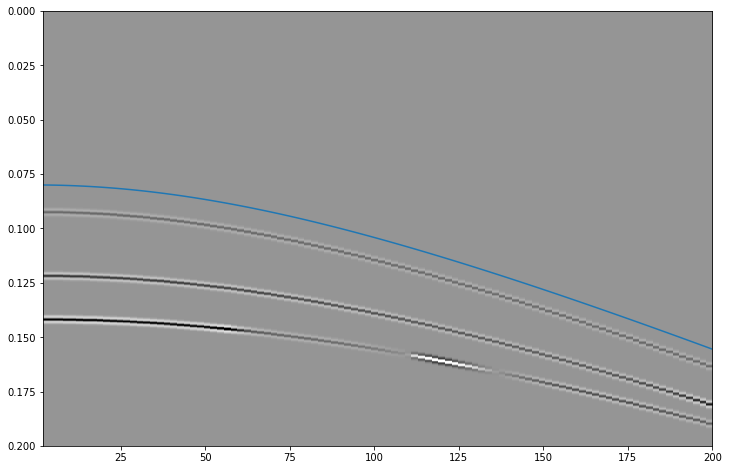

In [147]:
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, test_seismic[OWT.PdPu_water]['seismogram'], wiggles=False)
ax.plot(x_rec, start_times)
plt.show()

In [96]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"],
        start_indexes=start_indexes
    )

## Create optimizers

In [103]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 50000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= True,
          polish= True,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [79]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
        factr=100,
        maxls=50,
        pgtol=1e-7,
        epsilon=1e-7,
        iprint=1,
        disp=1
    )
]

In [55]:
optimizers_cg = [
    ConjugateGradient(
    )
]

In [56]:
optimizers_ax = [
    AxOptimizer(num_evals=30, log_scale=False)
]

In [57]:
min_vals = forward_params['model'].get_optimization_option('min', vectorize=True)
max_vals = forward_params['model'].get_optimization_option('max', vectorize=True)
start_vals = np.random.uniform(min_vals, max_vals)

print(min_vals, max_vals)
print(start_vals)

[10.   1.   2.   0.5  0.5] [50.   20.    2.5   0.99  0.99]
[25.4009383  12.09394368  2.02967913  0.8513938   0.9861497 ]


In [58]:
start_vals = forward_params['model'].get_optimization_option('val', vectorize=True)*0.9
start_vals

array([19.35 ,  6.3  ,  2.187,  0.63 ,  0.666])

In [123]:
start_vals = [0.85, 0.7]

In [59]:
forward_params['model'].set_optimization_option(start_vals)

func_to_optimize(forward_params['model'].get_optimization_option('val', vectorize=True), placeholders, forward_params, helper=None, show_tol=False)

/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.812171525028299

## Check sensitivity

In [59]:
def func_(xk):
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

def func_min_max(xk):
    xk = min_vals + xk * (max_vals - min_vals)
    
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

nrepeats = 5

grads = []

for i in range(nrepeats):
    start_vals = np.random.uniform(min_vals, max_vals)
    start_vals_minmax = (start_vals - min_vals) / (max_vals - min_vals)
    
#     grads.append(approx_fprime(start_vals, func_, epsilon=[1e-6]*len(start_vals)))
    grads.append(approx_fprime(start_vals_minmax, func_min_max, epsilon=[1e-6]*len(start_vals)))
    
grads

[array([-0.02389677, -0.00118447,  0.00511412, -0.07431884, -0.01222486,
         0.00653593,  0.03492057,  0.7575626 ]),
 array([-4.24749347e-03, -8.83493279e-05,  1.44636645e-02, -5.81149443e-01,
        -7.33540736e-01,  2.00665568e-01,  2.51103741e-01,  1.19375249e+00]),
 array([ 4.11396750e-03, -1.05365716e-05, -1.22040432e-02,  2.56779170e-02,
        -3.54525004e-02, -4.24796873e-02, -7.71417930e-04,  9.28113112e-02]),
 array([-3.84250498e-03, -2.86084045e-04,  1.64208513e-03, -1.49465619e-01,
        -1.13557008e-02,  2.29438997e-02,  5.07049505e-02,  1.24711769e+00]),
 array([ 4.01821598e-03, -1.63325631e-04,  1.22964465e-02,  1.57634512e-02,
        -1.44172000e-02,  4.02019774e-02,  6.72925271e-04, -3.21535841e-01])]

In [98]:
model.get_optimization_option('val')

OrderedDict([(1, {'Vsh': 0.7, 'phi': 0.74})])

# Run inversion process

In [104]:
# scale="minmax"
scale=None
# scale="lg"

start_time = time.time()
inversed_vals, stats = inverse(optimizers_de, error=None, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"time: {time.time() - start_time}")

/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.44711063088758285
2.510246127829943


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.9326769086864602
2.0641434034486883


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.7762614141576663
1.834249250670578


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.827790239088381
1.726303159367971


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


1.6660876833948304
1.1225996292788514
2.436328182375126
0.47662487690421873
2.716061621983836
1.1990076385440689
2.4810085858529916
2.675473277639763
1.7807026733487759
1.3829155241277558
2.7950684807439026
0.5291830806115521
2.76558814047248
differential_evolution step 1: f(x)= 0.447111
2019-11-02 15:02:20.200665
1.4851347851059693
0.4165909838901662
2.108975563167798
1.568805787225312
1.657881007913326
2.649825506450372
0.9770000885194058
1.542686042487309
1.8945836111037442
differential_evolution step 2: f(x)= 0.416591
2019-11-02 15:02:20.642163
1.0016567818678277
2.8635842315113473
0.5555588702689944
1.1090699377635829
1.9027947742280744
1.0678437324720753
1.7671516405408954
1.0355744618851501
2.2308056080209084
0.08619755610777294
1.1556676862072228
differential_evolution step 3: f(x)= 0.0861976
2019-11-02 15:02:21.101847
1.131907508616565
1.6408982801729564
1.1641539643047432
1.9327053295710666
2.2418365938322418
0.7045538357515536
0.6041762771172944
1.1337338020578085
2.49346302

1.9810927374526455
0.08216211574887929
0.026286472398880222
0.376312669323923
0.06849296167847828
0.08593042868943866
0.0475803770716566
0.1002402219078846
0.16124512099254956
0.17073315878060932
differential_evolution step 32: f(x)= 0.00801585
2019-11-02 15:02:36.035474
0.01666830711287607
0.5318808345316383
0.7073279966826339
0.08593042868943866
0.01666830711287607
0.1855238595748379
0.07726128991523298
0.18571511245641872
0.8820671473119325
0.16124512099254956
0.011549031222871124
differential_evolution step 33: f(x)= 0.00801585
2019-11-02 15:02:36.539147
0.1855238595748379
0.7655974835846988
1.0205411766968742
0.27872680708151704
0.2597661817213298
0.19594922017345381
0.5186408218134401
0.5169003999616429
1.0791319349100077
differential_evolution step 34: f(x)= 0.00801585
2019-11-02 15:02:37.098906
0.180171617627216
0.02370296725121592
0.049390781627899866
1.067931015481893
0.05405798640749062
0.05006631583304463
0.5440863899766152
0.13058278396088127
0.8994797665739329
0.896222121

/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.008015854115642542
0.008015879774573732
3.369906928955866
3.3699069286221097
3.369906941785376
0.1343687028784256
0.13436870174299828
0.13436868446347242
0.007930462473096265
0.007930463880234344
0.007930489517690171
0.07817560258809897
0.07817560136052766
0.07817558025531775
0.00786498129452253
0.00786498270682153
0.00786500832031327
0.05092098417657415
0.05092098290159382
0.05092096014497594
0.007819608768090968
0.007819610184718261
0.00781963577556108
0.03513056622120827
0.03513056488819294
0.03513054099543144
0.00778927068108649
0.007789272101061093
0.007789297672724514
0.01222666294572892
0.012226661593564475
0.012226636058472238
0.007713434197370373
0.007713435627915592
0.007713461128524204
0.008054559021581297
0.008054557693328818
0.008054531845539788
6.158843749297409e-05
6.158977531283268e-05
6.158827879366396e-05
6.124614856491337e-05
6.124727110219433e-05
6.123928610872017e-05
5.4616990860523805e-05
5.461822150115099e-05
5.4612958283687894e-05
6.475212493624514e-05
6.47522

In [105]:
forward_params['model'].set_optimization_option(inversed_vals)
forward_params['model'].scale=None
inversed_vals = forward_params['model'].get_optimization_option('val', vectorize=True)

In [106]:
inversed_vals

array([0.70000005, 0.73999999])

In [107]:
result = {key: {
    "real": val,
    "inversed": inv
} for key, val, inv in zip(true_vals[1].keys(), true_vals[1].values(), inversed_vals)}
result

{'Vsh': {'real': 0.7, 'inversed': 0.7000000520567508},
 'phi': {'real': 0.74, 'inversed': 0.7399999924754297}}

In [103]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

NameError: name 'inversed_model' is not defined

In [68]:
time_1 = time.time()
func_to_optimize(inversed_vals, placeholders, forward_params, helper=None, show_tol=False)
print(time.time() - time_1)

0.1377875804901123


Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


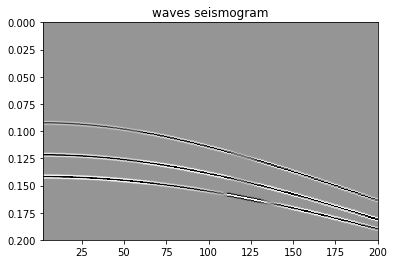

In [65]:
res_observe, res_seismic = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [ ]:
diff = test_seismic[OWT.PdPu_water]['seismogram'] - res_seismic[OWT.PdPu_water]['seismogram']
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, diff, wiggles=False)
plt.show()

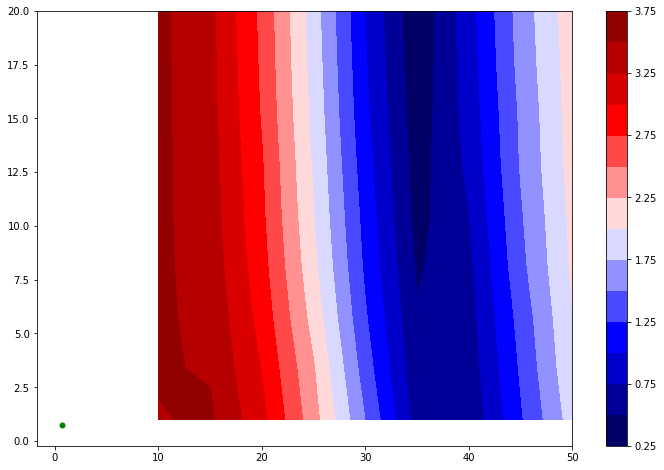

In [136]:
fig, axes = plt.subplots(figsize=(12,8))

plot_2D_err(forward_params, [8, 8], 15, points=[[inversed_vals[0]], [inversed_vals[1]]], fig=fig, ax=axes)

plt.show()

# Extra plot

/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


256.30693078041077


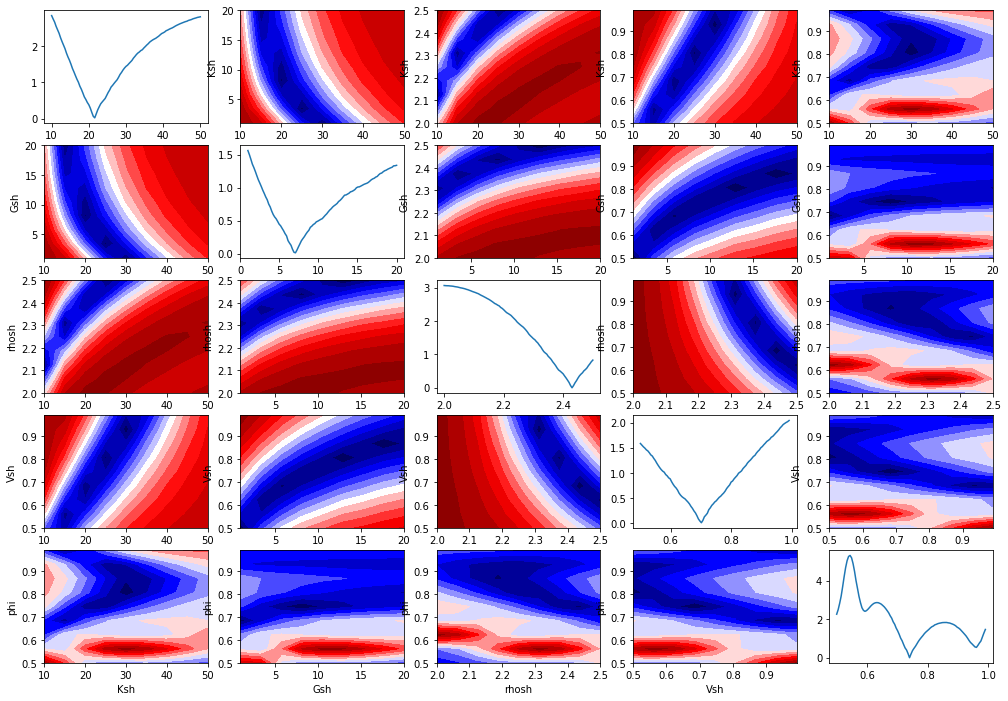

In [146]:
start_time = time.time()

optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

fig, axes = plt.subplots(len(optimization_list), len(optimization_list), figsize=(17,12))

for i, ol1 in enumerate(optimization_list):
    for j, ol2 in enumerate(optimization_list):
        layer_2_rp = get_layer2_rp()
        for key in layer_2_rp['components'].keys():
            if key in (ol1, ol2):
                layer_2_rp['components'][key]["optimize"] = True
            else:
                layer_2_rp['components'][key]["optimize"] = False
                
        layer_2 = Layer1D(h[1],
              rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
              seism_attribute=None,
              opt=LayerOPT.RP)

        forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

        if ol1 == ol2:
            plot_1D_err(forward_params, 100, ax=axes[i, j])
#             axes[i,j].set_title(ol1)

        else:
#             print(ol1, ol2)
            plot_2D_err(forward_params, [8, 8], 15, fig=fig, ax=axes[i, j])
            axes[i,j].set_xlabel(ol2)
            axes[i,j].set_ylabel(ol1)
            
        
        
print(time.time() - start_time)
                
plt.show()
            
          

# Repeats optimizations

In [148]:
import itertools

In [154]:
start_time = time.time()

optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

results = []
nrepeats = 5

for comb in itertools.combinations(optimization_list, 2):    
    res_tmp = []
    stats_tmp = []
    layer_2_rp = get_layer2_rp()
    for key in layer_2_rp['components'].keys():
        if key in (comb[0], comb[1]):
            layer_2_rp['components'][key]["optimize"] = True
        else:
            layer_2_rp['components'][key]["optimize"] = False

    layer_2 = Layer1D(h[1],
          rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
          seism_attribute=None,
          opt=LayerOPT.RP)

    forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])
    
    for i in range(nrepeats):
        inversed_vals, stats = inverse(optimizers_de, error=None, 
                                       placeholders=placeholders, 
                                       forward_params=forward_params, scale=None)
        forward_params['model'].set_optimization_option(inversed_vals)
        res_tmp.append(forward_params['model'].get_optimization_option('val'))
        stats_tmp.append(stats)
        
    results.append({
        "name": f"{comb[0]}_{comb[1]}",
        "vals": list(res_tmp),
        "stats": list(stats_tmp)
    })
    
print(time.time() - start_time)

/home/apenkin/.local/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:461: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning

1.705210960266753


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


0.05393964209239903


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.3837055183978166


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.7339490416936171


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


0.17793237050059335
2.791539474418772


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.2068123861355255


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.6731424380326017
1.646941087283158
2.615690387564519
2.246210003759808
0.729119728812758
1.9814614885877084
1.7356422720499243
2.1247717300317017
1.5831520383294837
2.3551428195827047
2.7865181395074696
1.4104641810820464
2.3570838128816076
differential_evolution step 1: f(x)= 0.0539396
2019-11-07 16:47:58.281529
1.4393953497094287
2.882677330017002
2.279053399025098
2.7822450581106213
0.11789319691065613
1.4641381265002729
2.9082837984198115
2.6938303619425876
2.3596594188937785
0.29206698560269256
differential_evolution step 2: f(x)= 0.0539396
2019-11-07 16:47:58.951252
1.9055769097665498
2.4702966101108634
1.829717628015117
1.8250582685256378
2.759129390454293
2.3547748711035688
2.1929472525113436
2.0068560700638884
2.3670911152976584
0.9955957050098735
differential_evolution step 3: f(x)= 0.0539396
2019-11-07 16:47:59.575223
1.0581377360494126
1.0418050916855957
2.7731903137610785
1.2597272430505788
2.3366347042746725
1.6668075834293963
1.9072814136525407
2.697562146697133
1.0563

0.5926027447551737
differential_evolution step 31: f(x)= 0.00126644
2019-11-07 16:48:18.956065
1.676352348275438
0.017725568704740423
0.7548486678167512
0.06570497607176395
0.38442884314862585
0.12296532012461356
1.093159170272246
0.06165558599193012
0.12556191246641157
1.9719562457372302
differential_evolution step 32: f(x)= 0.00126644
2019-11-07 16:48:19.872020
0.9359710459081968
2.1690637917711433
0.24741110715404233
0.1765328215040086
2.0549571320380116
0.12251709131550818
0.1857059820223052
1.986389406964908
0.8910074619696249
1.8218470208479662
differential_evolution step 33: f(x)= 0.00126644
2019-11-07 16:48:20.557921
0.14152576291896768
0.5087269878841354
0.19276160592277838
0.2855833217096433
1.8780460035749376
0.7250652373479
0.07103199571532072
0.9979823829986616
0.7451394939558195
0.35554701137284883
differential_evolution step 34: f(x)= 0.00126644
2019-11-07 16:48:21.207047
0.22757337389640178
0.9650782850032192
0.10557129021804615
0.1179846330211871
0.5150287639577976
2.3

/home/apenkin/.local/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


0.0012664435262234707
0.0012664435750736696
0.0012535493304330722
0.0012535493004189751
0.001253549348926464
0.011652491264371814


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.011652491271416005
0.011652491306003845
0.0012423266565276972
0.0012423266273549748
0.0012423266757163596
0.011856486677273629
0.011856486669568489
0.011856486711601501
0.0012376336264040921
0.0012376335975690883
0.0012376336458687729
0.012011732713192587
0.012011732699343096
0.012011732743404061
0.0012356361740824696
0.0012356361453901908
0.0012356361936634043
0.008429888127381952
0.008429888109225823
0.008429888154675743
0.0012345224865869884
0.0012345224579723534
0.001234522506235207
0.004787334286489554
0.0047873342658663375
0.004787334311881756
0.0012335589388181262
0.001233558910272844
0.00123355895852178
0.004833191327355563
0.004833191304775383
0.004833191351197791
0.0012331459068342628
0.0012331458783179513
0.0012331459265613155
0.004863778932662069
0.00486377890857896
0.004863778955296295
0.0012329678380016077
0.0012329678094955682
0.0012329678577367661
0.0011921194861819315
0.0011921194602644157
0.0011921195080302758
0.0011784087042331448
0.0011784086790685609
0.0011784087

3.1074983599389223
2.7554372105991582
1.9453229267803183
0.4580577867512281
1.011693026927858
0.5573277234861727
0.22866482716695619
2.2041592103213152
2.309263711037473
differential_evolution step 9: f(x)= 0.157925
2019-11-07 16:49:23.688170
1.1433542191330133
2.070802538329268
2.097083929946633
2.5401250975184397
0.3133624556968925
0.8180432591002763
2.3414560474175796
0.6811358036355386
1.1345532252973294
0.6884429930342062
differential_evolution step 10: f(x)= 0.157925
2019-11-07 16:49:24.461457
0.6885086915500033
2.1862013029386445
2.7421375150896132
0.6618936098382923
0.22866482716695619
0.727267411841194
0.27843889896161494
1.727070318825533
0.488051050234599
2.6016420368439404
differential_evolution step 11: f(x)= 0.157925
2019-11-07 16:49:25.111802
0.35832690878290835
1.8425202010496091
0.4076605376973905
0.3721772858842856
0.024722967687606054
1.2655702380702363
0.6595877636195683
1.7219761303787042
0.1664987866289017
0.7181649612521916
differential_evolution step 12: f(x)= 0

differential_evolution step 39: f(x)= 0.00588245
2019-11-07 16:49:45.408906
0.07611711098453697
0.11167311713336865
0.10035772449385304
1.2996097470711905
0.27563173910098643
0.8870483307101442
0.1277534930224576
1.4302835415903263
0.9374659727311846
0.03940539390109336
differential_evolution step 40: f(x)= 0.00588245
2019-11-07 16:49:46.269467
0.05308776375442511
0.017136062720121706
0.004401376971713237
0.0008002097486406693
0.017136062720121706
0.015222048057746384
1.1778319789793419
0.18891821087448193
0.1298756504388468
0.008102786795137405
differential_evolution step 41: f(x)= 0.00080021
2019-11-07 16:49:47.041135
0.1434606870657968
0.023907093763035542
0.011751758310319061
0.30674827741877725
0.25908475753369514
0.5094267533678944
0.5575520559320137
0.10001075756853602
0.023218253615159182
0.02517020710520573
differential_evolution step 42: f(x)= 0.00080021
2019-11-07 16:49:47.846191
0.054435195339740616
0.13141500072262452
0.323669827783208
0.3234922521290532
0.0135334692636508

0.007580597870630139
0.007580597909704956
0.007580597917438116
2.0178191174428134e-05
2.017819010573181e-05
2.0178150572904506e-05
2.334389781260998e-05
2.334396236931859e-05
2.3343935225595737e-05
1.2257117943920321e-05
1.2257177914415215e-05
1.2257126592729205e-05
1.5055551800815465e-05
1.5055535863075845e-05
1.5055582063841008e-05
2.6708909849781435e-06
2.6709538901122252e-06
2.670930043728384e-06
2.6323249177775817e-05
2.6323182301594314e-05
2.6323230462826545e-05
2.3341814834527e-06
2.3341580292573753e-06
2.334205828840874e-06
4.363184146956795e-06
4.363156392223745e-06
4.363136649576759e-06
1.7678068735825502e-06
1.7677396279537204e-06
1.7677872710644583e-06
3.3986846236528214e-06
3.3987004958388497e-06
3.398654297067123e-06
8.742655731807285e-07
8.742107752867802e-07
8.742215888728311e-07
1.1617775128885528e-06
1.1618441723544113e-06
1.1617957905060082e-06
4.712447061198219e-07
4.7123895474419647e-07
4.712021499214985e-07
1.5561490845392497e-06
1.5561956744325067e-06
1.556195540

0.3816729434643849
0.45551837564995623
0.49125648423843
1.069741787657991
0.4837495822202859
0.4442136611767526
1.4991077444172827
2.407372932930463
1.1107873405928037
0.46507270123590233
differential_evolution step 23: f(x)= 0.0165057
2019-11-07 16:51:01.632425
1.3647875548209971
0.22958832394985781
0.20208785075457666
1.6702591667910258
0.34548147233890997
0.900865134870781
0.03382941837453788
2.012210494003605
0.3620767506889696
2.15567434007982
differential_evolution step 24: f(x)= 0.0165057
2019-11-07 16:51:02.300724
0.35516165390195753
0.8223282582902256
2.419930793043181
1.789294876579922
0.49125648423843
0.9310044055275568
0.15705666099512638
1.4494095202941388
1.0516487747148544
1.2423658489227698
differential_evolution step 25: f(x)= 0.0165057
2019-11-07 16:51:02.984725
0.5091820790391237
1.674066923473605
0.06544272763421781
0.3620767506889696
0.22958832394985781
1.3812144452542965
0.7029801221651559
0.06140708030595659
0.26907720793277345
0.9597580454612239
differential_evo

0.09543423376651405
1.585656500445968
0.33631315659325384
0.726919255176398
1.5638252063917777
0.49170198030854045
0.6376401393208434
0.02397665154061092
1.6557825179378074
0.4499005887296799
differential_evolution step 54: f(x)= 0.0089407
2019-11-07 16:51:26.794714
0.16855203599834198
0.00887919410613125
0.4184678858330874
1.0343985777932108
1.5172656373828675
0.12522710350254473
0.3846956385534754
0.6739740038103046
0.15307945784473737
0.1789932742165831
differential_evolution step 55: f(x)= 0.00887919
2019-11-07 16:51:27.432418
0.1328162071830198
2.007798336598045
0.22642089221097764
0.04641200378986191
0.026441880616485093
1.515376179981025
0.27693705222814863
0.4144249293866122
0.33222039317276547
0.3841678749413377
differential_evolution step 56: f(x)= 0.00887919
2019-11-07 16:51:28.088234
0.37177015133116353
0.2794937139027855
0.55704124909347
0.442899576496615
0.9204894371700341
0.07112546289889321
0.33631315659325384
0.4798393533315706
1.0194479712553357
0.92685609185858
diffe

0.1502178467353308
0.25928946373133455
0.15444851502642415
0.21324193533498798
0.026673929037924538
0.021899158625716047
differential_evolution step 84: f(x)= 0.00249138
2019-11-07 16:51:51.145975
0.10613341330054449
0.44060720505170126
0.3305920615838784
0.5309432458749126
0.04195537415656137
0.15444851502642415
0.5735362568284466
0.10613341330054449
0.3598908720212111
0.17485279910221632
differential_evolution step 85: f(x)= 0.00249138
2019-11-07 16:51:51.850520
0.04195537415656137
0.0024913825629501512
0.0113114753155091
0.15444851502642415
0.021899158625716047
0.014860017736389277
0.3094804869405089
0.18661926868217366
0.027026765531435914
0.04374977808091667
differential_evolution step 86: f(x)= 0.00249138
2019-11-07 16:51:52.665808
0.0024913825629501512
0.5877132361169749
0.4332938462636229
0.06709077470157944
0.2962996899261185
0.0024913825629501512
0.5181138501662375
0.0024913825629501512
0.0024913825629501512
0.0024913825629501512
differential_evolution step 87: f(x)= 0.002491

0.5520647991889784
1.911127229659344
0.2944722476839546
0.9727294058083001
1.265535655952962
0.06213422297528017
0.08691603197301438
1.0131492673720643
0.2377340461459897
0.3036582075172494
differential_evolution step 10: f(x)= 0.0225356
2019-11-07 16:52:33.086304
0.08691603197301438
0.5010431026505889
0.16009203709034345
0.0922975911113389
2.4091246726707025
0.08691603197301438
2.3671631709163172
0.19175903412547202
0.05701798787519392
1.4442628523548477
differential_evolution step 11: f(x)= 0.0225356
2019-11-07 16:52:33.705142
1.3562928661207374
0.39900787762223666
0.1672847668926655
0.9058686736281393
1.465979492434607
0.16271982041729155
0.12608626611064114
0.5615988610106308
0.30035325235834065
0.37316222137322264
differential_evolution step 12: f(x)= 0.0225356
2019-11-07 16:52:34.325962
0.4527437933425816
0.16778994136069655
0.8837250508375492
0.49582672008167417
0.697204904418181
1.9470639209140956
0.35357284906146774
0.40043616592911074
0.1635037288000611
0.1637437450819828
dif

0.02253560204706247
0.03207104589011932
0.08446366467100509
0.022535602047062876
0.09612344669438888
differential_evolution step 40: f(x)= 0.0183724
2019-11-07 16:52:52.636938
0.03207104589011961
0.01837239124699231
0.0692676666858096
0.13802492415547768
0.04753345041194483
0.03149839170237699
0.04725401657008537
0.05766194304648544
0.01837239124699194
0.024730742268654477
differential_evolution step 41: f(x)= 0.0183724
2019-11-07 16:52:53.290803
0.047533450411945156
0.026613746107906722
0.01837239124699194
0.01837239124699194
0.07981782251503085
0.02661374610790604
0.03207104589011971
0.02661374610790609
0.05356141120316134
0.04723252626101762
differential_evolution step 42: f(x)= 0.0183724
2019-11-07 16:52:53.941505
0.01837239124699194
0.06755364281705074
0.01837239124699194
0.026613746107906722
0.01837239124699194
0.1069180630569028
0.031498391702377136
0.01837239124699214
0.01837239124699189
0.01837239124699194
differential_evolution step 43: f(x)= 0.0183724
2019-11-07 16:52:54.570

0.021680334320108
0.018264398353192584
0.018264398305929148
0.018264398358639772
0.0182643982981779
0.01826439825091507
0.018264398303625595
0.018264396963186193
0.018264396915922253
0.018264396968632933
0.018264396963186193
0.018264396915922253
0.018264396968632933
0.02165823730068717
0.021658237254916637
0.021658237306399965
0.021680311024755906
0.021680310978293343
0.021680311030145054
0.01826439696315546
0.01826439691589213
0.018264396968602697
0.018264396963006857
0.018264396915743993
0.018264396968454933
0.021680323325864566
0.021680323279400254
0.021680323331252492
0.018264396962999318
0.018264396915736295
0.018264396968446856
0.0182643969629915
0.018264396915728755
0.018264396968439452
0.021680329476447373
0.02168032942998314
0.02168032948183518
0.018264396962989836
0.018264396915726747
0.018264396968437
0.018264396962987303
0.018264396915724873
0.018264396968435778
0.021680332551745122
0.021680332505280824
0.021680332557133686
0.018264396962986925
0.018264396915724488
0.018264

differential_evolution step 25: f(x)= 0.00540897
2019-11-07 16:54:04.856338
0.3981723237190777
0.15665947317149295
0.014516827743024013
0.2010201050017676
0.28494202247217526
0.0029697182214083826
0.31288138681897976
0.33548136106426146
0.009087239886196271
0.0029697182214083826
differential_evolution step 26: f(x)= 0.00296972
2019-11-07 16:54:05.474730
0.13055873389434455
0.11433954979203471
0.24197981219400266
0.03890179257802733
0.8576053611875079
0.07406972648830984
0.1921025847247529
0.01391354968624923
0.013358929692689508
0.01240356898956189
differential_evolution step 27: f(x)= 0.00296972
2019-11-07 16:54:06.112880
0.19583344923009163
0.05370725652754875
0.1248047377771899
0.7457270000550484
0.47565277735178507
0.3033899559861365
0.08720872039677023
0.13437361779538842
0.0010452590078078331
0.0887618392224545
differential_evolution step 28: f(x)= 0.00104526
2019-11-07 16:54:06.747857
0.04188892250173785
0.03660850363577967
0.3919850306602469
0.023515167991956666
0.0010452590078

7.334341618234255e-09
1.1007479824552321e-07
1.1000681509661694e-07
1.1005307599965716e-07
1.043593673902886e-08
1.0372873127830868e-08
1.0423544144264372e-08
4.338472777234742e-09
4.3514314116999335e-09
4.383330482338471e-09
3.0832128904569734e-08
3.0787170040776614e-08
3.0785371026488834e-08
2.9135286321066965e-09
2.844856485756407e-09
2.8853715220921574e-09
DE stat:
x: [21.49999959  6.99999996]
fun: 2.9135286321066965e-09
nfev: 621
nit: 35
message: Optimization terminated successfully.
success: True
jac: [-0.00686721 -0.00281571]

2.644922155335039
2.9947596694560623
2.9115345166259052
2.2700720046809697
2.595248896342089
2.706096214024068
0.24362364109752357
0.06762891105023915
2.845580403830658
2.189993935265892
1.0234594786810223
2.230477404508954
2.907713467961173
0.5658008836314525
0.6108353337279209
2.938470294385881
2.749998364924572
2.259124880536602
2.790344777716742
3.0156349851622397
differential_evolution step 1: f(x)= 0.0676289
2019-11-07 16:54:50.668240
2.6132127397680

0.037473842439587526
0.03747384248429704
0.03747384244585909
0.034027050715726155
0.034027050761372045
0.034027050699645144
0.05498932297982697
0.054989323025809424
0.054989322738883545
0.034027040202354725
0.034027040248000406
0.03402704018620551
0.03747262164864286
0.037472621693458254
0.03747262164783568
0.03402704012389995
0.03402704016954609
0.034027040107752225
0.03402704004545539
0.034027040091102585
0.034027040029307246
0.03747327967263612
0.037473279717391055
0.037473279675846224
0.03402704002584677
0.03402704007149452
0.034027040009698334
0.03402704000623899
0.03402704005188595
0.03402703999009077
0.03747361128072137
0.037473611325445785
0.03747361128594767
0.034027040001337786
0.034027040046983974
0.0340270399851891
0.037473724424214226
0.03747372446892933
0.037473724430127586
0.03402703999920308
0.03402704004485095
0.03402703998305349
0.03402703999706835
0.034027040042715555
0.03402703998091788
0.03747383443137956
0.03747383447608461
0.03747383443795967
0.03402703999653545


0.018892738539311883
0.022406390202430047
0.02240639024452457
0.022406390541526214
0.018892737937186755
0.018892737979636386
0.01889273828416051
0.018891234553217753
0.018891234595861027
0.01889123488748
0.022406653167746076
0.022406653209807087
0.022406653509074146
DE stat:
x: [25.16924148  2.48945006]
fun: 0.022406653167746076
nfev: 723
nit: 23
message: Optimization terminated successfully.
success: True
jac: [0.00423714 0.03522634]

2.437966448568625
1.6390279284488287
1.6119950457941912
0.412107221910842
2.8888125759518264
2.7750392162970225
2.6453819061863864
2.957166970003822
1.1242459253407506
3.0204183488558756
0.5114873021677662
3.026624034980149
0.9193590953432371
0.8082582389033431
2.1746833172584763
2.779827886422693
2.8053717496741513
2.6351408859346757
0.17172221929354198
2.9961957322301362
differential_evolution step 1: f(x)= 0.171722
2019-11-07 16:56:22.509051
0.29290141455466384
2.684368482757838
2.8368739595919252
1.8538359103731912
2.8525261038444216
2.02104245367752

2.9420227842662894
0.07516275270281707
0.9396080377575873
0.7721893593534004
0.867675658876994
0.3459422441693753
1.8832784019540763
0.07176903492860282
0.15868409631129068
1.8005954443473744
differential_evolution step 30: f(x)= 0.0283952
2019-11-07 16:56:42.333113
0.13183895272251667
0.1434232185380833
0.9635997072824014
0.04426565766072077
0.5816686381330456
3.0395675757751985
0.7721893593534004
0.19012021190041686
0.9543671278022006
2.596664342750176
differential_evolution step 31: f(x)= 0.0283952
2019-11-07 16:56:43.099627
0.17254222587918855
2.0197608467819035
1.4650222696194455
0.07080379916297767
0.9655073938689334
2.519809611756544
0.3459422441693753
1.9329646339947206
0.1425609292460565
0.07898585849432178
differential_evolution step 32: f(x)= 0.0283952
2019-11-07 16:56:43.786662
1.3434601175497416
0.17770275984645345
0.22573216788612108
1.9574860459388463
0.01760057345005599
0.15106192020892387
0.22860067424783043
1.3524678183392704
0.03997164429821363
0.5129327130582356
dif

0.0074223286869657045
0.18078381370277966
0.3003165554114155
differential_evolution step 60: f(x)= 0.00742233
2019-11-07 16:57:05.030110
0.012347347053736477
0.07643621407386486
0.10594387157668617
0.02441036412808415
0.3639889937419747
0.419750961450475
0.012689098174458523
0.4262758855825163
0.0074223286869657045
0.012347347053736477
differential_evolution step 61: f(x)= 0.00742233
2019-11-07 16:57:05.734804
0.0074223286869657045
0.01534250745711428
0.12029799990923168
0.01534250745711428
0.02441036412808415
0.030175955596457596
0.06709018116581963
0.0074223286869657045
0.0074223286869657045
0.06709018116581963
differential_evolution step 62: f(x)= 0.00742233
2019-11-07 16:57:06.590650
0.4284532081498446
0.06709018116581963
0.5114016647853177
0.0074223286869657045
0.0074223286869657045
0.3003165554114155
0.2897081425366527
0.023389657400763045
0.4908303812902647
0.012347347053736477
differential_evolution step 63: f(x)= 0.00742233
2019-11-07 16:57:07.546447
0.0074223286869657045
0.00

1.511638669475412
0.9501444784818525
3.0581804947993563
0.7705798388296126
0.15297185657257092
2.200277140080797
1.0159310490478781
0.25486381500651734
0.22283612804351305
0.09599321746690864
differential_evolution step 9: f(x)= 0.0651196
2019-11-07 16:57:47.083928
2.5037909589867398
2.07185052389079
0.6193799282931965
0.6193799282931965
2.4054413260248295
0.4645827914039779
1.2639947415850656
2.646206784927159
2.8576837849899146
1.0893007437507707
differential_evolution step 10: f(x)= 0.0651196
2019-11-07 16:57:47.954544
0.5405247069912561
2.085478716893613
1.1741249169698287
1.3477571372417574
0.8387809823398923
1.3674400725275717
0.8387809823398923
0.16735573820056446
2.8850060615066773
2.2327809717143996
differential_evolution step 11: f(x)= 0.0651196
2019-11-07 16:57:48.592727
2.393767939114709
0.9728531888194898
2.930876467443174
1.8665360386167242
1.4656518850386184
3.0126750417491013
1.552611821556321
0.36110344879117146
2.997573517952802
1.175017811803777
differential_evolutio

differential_evolution step 39: f(x)= 0.0433126
2019-11-07 16:58:11.422956
0.047952985623519816
0.2658220358654425
0.5261161569177479
0.06739429622463293
0.49283782606647525
0.07082924920835369
0.044191799469507076
0.04483893773144
0.08984175977739933
0.044191799469507076
differential_evolution step 40: f(x)= 0.0433126
2019-11-07 16:58:12.202161
0.10281836433219622
0.3474719385516131
0.4155038330605997
0.047952985623519816
0.22204640189484107
0.043312559123825756
0.3493672847845399
0.07566474890047123
0.052706661311093195
0.051698084587068656
differential_evolution step 41: f(x)= 0.0433126
2019-11-07 16:58:12.981397
0.07163948165411935
0.044191799469507076
0.060084743566677624
0.31764179923280417
0.052706661311093195
0.047952985623519816
0.5906007758107796
0.047952985623519816
0.044191799469507076
0.4493688113648547
differential_evolution step 42: f(x)= 0.0433126
2019-11-07 16:58:13.797620
0.41362740410660637
0.17265665427760718
0.043312559123825756
0.07163948165411935
0.07835130513839

0.0465343524797458
0.04653435215524385
0.04330542843063486
0.04330542835743781
0.04330542805169853
0.046534424228543626
0.046534424156648775
0.04653442383191672
0.04330542842971783
0.04330542835652036
0.043305428050781566
0.043305428428802306
0.0433054283556039
0.04330542804986561
0.04653449383382107
0.04653449376193232
0.046534493436976375
0.04330542842857242
0.04330542835537505
0.043305428049635455
0.043305428428343354
0.04330542835514602
0.04330542804940648
0.04653452865006574
0.04653452857818017
0.046534528253111045
0.04330542842828608
0.0433054283550882
0.04330542804934976
0.04653454048967096
0.04653454041778619
0.046534540092679794
0.04330542842826086
0.04330542835506345
0.043305428049324586
0.04330542842817502
0.043305428354976784
0.04330542804923787
DE stat:
x: [15.04914567  2.29797644]
fun: 0.04330542842817502
nfev: 796
nit: 51
message: Optimization terminated successfully.
success: True
jac: [-0.00731962 -0.03789382]

2.484512589116203
3.047875302061822
2.440124869346389
2.81

1.5795908508751706
0.0900600620128603
0.0900600620128603
0.5040073392466438
0.761972731390851
1.7286835236461733
3.0247682807170797
1.0073853061523836
0.10771131349081849
0.9610358319093262
differential_evolution step 28: f(x)= 0.00901167
2019-11-07 16:59:27.415456
0.1276135172228013
0.13286353700071518
0.6690897096936997
2.9680854411998214
1.7423040916217207
0.036984600350884564
3.025273796175474
0.9038660639514663
3.0303771818742113
1.225258049431174
differential_evolution step 29: f(x)= 0.00901167
2019-11-07 16:59:28.213845
1.0801924468793114
0.16639109365266744
0.4264925480493925
2.7226128594381445
3.0269568883145683
1.1253058956301276
0.1338344622667101
0.44733901675493304
0.15005560352093378
0.0900600620128603
differential_evolution step 30: f(x)= 0.00901167
2019-11-07 16:59:29.113168
3.0512017790993986
2.7034769402585486
0.07164318749631349
0.9882600334421853
1.8340288047537798
2.555644355414044
0.48680595945354294
0.06609539207029362
1.12967788802642
2.6344048568430236
differen

0.4536341948625773
0.009011674595295177
0.009011674595295177
differential_evolution step 58: f(x)= 0.00901167
2019-11-07 16:59:51.027090
0.04840209410743285
0.009011674595295177
0.04840209410743285
0.04840209410743285
0.18194496860106513
0.009011674595295177
0.009011674595295177
0.009011674595295177
0.18194496860106513
1.5892487300609437
differential_evolution step 59: f(x)= 0.00901167
2019-11-07 16:59:51.850267
0.009011674595295177
0.009011674533076887
0.009011674998119773
0.5011428172754477
0.5011428172759372
0.5011428168460599
0.0090107600607305
0.009010759998803203
0.009010760445878776
0.2937081808985491
0.2937081808969845
0.29370818033627255
0.005308285651995065
0.005308285590019281
0.0053082860196584656
0.005308285646379272
0.0053082855844035996
0.005308286014043725
0.14799415159444546
0.14799415159260526
0.147994150024441
0.005308117876185478
0.005308117814273358
0.00530811823999767
0.0016123488281253998
0.0016123487776823447
0.001612348481898323
0.0016110621737995632
0.00161106

0.00516397158580413
0.0051639705857138875
0.0014965731094241576
0.0014965730652642551
0.0014965724117670383
0.0014873500341808152
0.0014873499926355937
0.0014873491920324004
0.0014780951321661507
0.0014780950926404366
0.0014780941800504638
0.012472240147222827
0.012472240115947844
0.01247223885788545
0.0014778846429918872
0.00147788460349455
0.0014778836894114022
0.005155551306106781
0.005155551269274021
0.0051555502458670134
0.0014778708662580029
0.0014778708267583934
0.001477869912577599
0.001477857111255504
0.0014778570717602683
0.0014778561574814869
0.005163686880148481
0.005163686842487219
0.005163685863743569
0.00147785367956119
0.0014778536400666925
0.0014778527257626858
0.0014771415887402353
0.0014771415493356128
0.0014771406300363521
0.005167499220974207
0.005167499182876037
0.005167498227897776
0.0014771408701931288
0.0014771408307900167
0.0014771399114876043
0.005168807746412638
0.005168807708158074
0.005168806761821206
0.0014771405573374414
0.0014771405179337825
0.001477139

0.0013704989533235895
0.001370498006286545
0.0013704989904397321
0.0013704989515788372
0.0013704980045354527
0.0013704005652380466
0.00137040052638205
0.0013703995788384542
0.005065857015605369
0.0050658569775848036
0.005065856020356881
0.001370400565046969
0.0013704005261922887
0.001370399578649653
0.0013704005639224655
0.0013704005250686061
0.0013703995775238118
0.005065888822762829
0.005065888784738475
0.005065887827674691
0.0013704005639224655
0.0013704005250686061
0.0013703995775238118
0.034303234530642344
0.03430323450999178
0.034303232960345154
0.005064724956562686
0.005064724918633825
0.0050647239563856306
0.0013704004967374924
0.0013704004578868072
0.0013703995103401597
0.0013703967751654523
0.0013703967363136137
0.0013703957887550562
0.005065320630829232
0.005065320592852797
0.005065319633257849
0.0013703967584776323
0.0013703967196248958
0.001370395772064375
0.0013703967417868308
0.0013703967029382105
0.0013703957553739593
0.005065618680540068
0.005065618642536158
0.00506561

0.026869262993274783
0.02686926297110568
0.026869261434792017
0.004952496723857623
0.004952496686403644
0.0049524957003934
0.0012565703369503583
0.0012565702985808589
0.0012565693267635866
0.0012565682502234529
0.0012565682118536772
0.0012565672400232364
0.004952976531116611
0.004952976493617305
0.0049529755100099415
0.001256568239370764
0.001256568201000321
0.001256567229171382
0.0012565682285180537
0.0012565681901467315
0.0012565672183189691
0.004953216615532303
0.00495321657801085
0.004953215595613442
0.0012565682258047555
0.0012565681874364728
0.0012565672156061507
0.0012565681291293632
0.001256568090758304
0.0012565671189278648
0.004953336657194629
0.00495333661965909
0.0049533356378680645
0.0012565681284503784
0.0012565680900811932
0.0012565671182511548
0.0012565681224625898
0.0012565680840922625
0.0012565671122614175
0.004953396686814035
0.004953396649274362
0.004953395667784936
0.0012565681222922041
0.0012565680839233123
0.0012565671120926389
0.0012565681214680375
0.00125656808

0.0011397958242967104
0.0011397957864544867
0.0011397947880566936
0.0011397927315641384
0.0011397926937204183
0.001139791695307593
0.0048376138512523335
0.004837613814277033
0.004837612804269227
0.0011397927210825066
0.001139792683237661
0.0011397916848260327
0.0011397927106007683
0.0011397926727547854
0.001139791674342829
0.004837849918585877
0.004837849881587281
0.004837848872697758
0.0011397927079785754
0.0011397926701364593
0.001139791671724665
0.0011397926667330587
0.0011397926288909234
0.0011397916304778082
0.004837967973047318
0.004837967936038752
0.004837966927709973
0.0011397926660791913
0.0011397926282354282
0.0011397916298214294
0.001139792665422447
0.0011397926275821474
0.0011397916291680482
0.004838027010231677
0.004838026973219166
0.004838025965172622
0.0011397926652597357
0.0011397926274165308
0.001139791629002129
0.0011397926650959119
0.0011397926272519812
0.0011397916288374665
0.004838056531313175
0.004838056494297535
0.004838055486391956
0.0011397926650538077
0.001139

0.0010284697229640668
0.0010284686973120825
0.004727708247920728
0.004727708211482771
0.00472770717446558
0.0010284697529175638
0.0010284697156158025
0.001028468689964086
0.0010284695672400377
0.0010284695299394217
0.0010284685042854511
0.004727905657007731
0.004727905620547556
0.004727904584535347
0.0010284695654067077
0.0010284695281007918
0.0010284685024486433
0.0010284695635705292
0.001028469526268955
0.0010284685006150913
0.004728004394666369
0.0047280043581971005
0.004728003322686948
0.001028469563111791
0.0010284695258099426
0.0010284685001548087
0.0010284695626546587
0.0010284695253512648
0.001028468499697838
0.004728053771794037
0.004728053735318427
0.004728052700061622
0.0010284695625413253
0.0010284695252359968
0.0010284684995828302
0.00102846956242367
0.0010284695251224843
0.0010284684994686557
0.004728078462435415
0.004728078425960557
0.004728077390828827
0.0010284695623969465
0.00102846952509246
0.0010284684994387974
0.001028469562367098
0.0010284695250642292
0.0010284684

0.004539220367813263
0.0008461261729697218
0.0008461261090234291
0.0008461266454903176
0.0045418378262012185
0.0045418377622817585
0.004541838342316309
0.000846124741131453
0.0008461246771868149
0.0008461252136713398
0.0008425257408025326
0.0008425256761470488
0.0008425262589273308
0.0045424399982577695
0.004542439934433569
0.004542440507990589
0.0008425256774787386
0.0008425256128196729
0.0008425261956018666
0.0008425256141550826
0.0008425255494963812
0.0008425261322801806
0.000841935703040166
0.0008419356382815704
0.000841936227859349
0.004542639966191749
0.004542639902405011
0.004542640473769018
0.000841935703040166
0.0008419356382815704
0.000841936227859349
0.011907290598229217
0.01190729053173706
0.011907291375270227
0.000841879028321597
0.0008418789635579062
0.0008418795536778421
0.0045396449014329454
0.004539644837255141
0.0045396454345982195
0.0008418785167818043
0.0008418784520153698
0.0008418790421409202
0.0008418780053598566
0.0008418779405898383
0.0008418785307247828
0.0045

0.0007123237987374133
0.0007123249457948309
0.0007123249103104849
0.0007123237930872537
0.0007121477796515431
0.000712147744180636
0.0007121466263580095
0.0007120308695377564
0.0007120308340762142
0.0007120297158606036
0.0007120308695377564
0.0007120308340762142
0.0007120297158606036
0.04160180316369619
0.04160180322605015
0.041601802058753946
0.004411668996102874
0.0044116689616867264
0.004411667822414978
0.0007120301882394021
0.0007120301527774261
0.0007120290345621019
0.0007120295071735679
0.000712029471708852
0.0007120283534929503
0.004413573046547978
0.004413573012019726
0.004413571878540267
0.0007120293369681486
0.0007120293015058644
0.00071202818328755
0.004414221172950946
0.004414221138385156
0.004414220006903156
0.0007120292628485244
0.0007120292273836359
0.0007120281091652056
0.0007120291887285572
0.0007120291532668627
0.0007120280350484295
0.004414850559208702
0.004414850524601493
0.004414849395075159
0.0007120291702030868
0.0007120291347411545
0.0007120280165228483
0.000712

0.03384478435101678
0.033844782091012826
0.004298879133403266
0.004298879099703741
0.004298877925283235
0.0005947333332371523
0.0005947332986448153
0.0005947321372264734
0.0005947320223674485
0.0005947319877751375
0.0005947308263492619
0.004299240423078649
0.004299240389341608
0.004299239216749099
0.0005947320162025669
0.0005947319816069413
0.000594730820183617
0.0005947320100369533
0.0005947319754416867
0.0005947308140185471
0.004299421193333356
0.004299421159580185
0.004299419987902802
0.000594732008496269
0.0005947319739020563
0.0005947308124784129
0.004299550883990778
0.0042995508502234134
0.004299549679204947
0.0005947320083701997
0.0005947319737772031
0.0005947308123520645
0.0005947320080914129
0.0005947319734963903
0.000594730812071688
0.0042995764659529015
0.004299576432183028
0.004299575261295446
0.0005947320080604497
0.0005947319734668022
0.0005947308120400815
0.0005947320078807248
0.000594731973288463
0.0005947308118665914
0.0042995892574931
0.0042995892237230994
0.004299588

0.00045199988184270516
0.004157690310196059
0.004157690277815053
0.004157689038949534
0.00045200109985705725
0.0004520010665423121
0.00045199984270583233
0.00045200106072479764
0.000452001027409841
0.00045199980357876713
0.004158143330147702
0.004158143297710765
0.004158142061687852
0.00045200106072479764
0.000452001027409841
0.00045199980357876713
0.01890875355822073
0.018908753581748098
0.018908751290510978
0.004158073214208004
0.004158073181776352
0.004158071945566976
0.0004520010477186868
0.0004520010144042655
0.00045199979056913383
0.0004519997904683339
0.0004519997571518993
0.00045199853331183773
0.0004517316361765297
0.00045173160288748476
0.0004517303775143208
0.004158162016500356
0.00415816198405517
0.004158160748366478
0.0004517316347633925
0.00045173160148246483
0.00045173037610783646
0.00045173162656052463
0.0004517315932752758
0.00045173036790338296
0.00045164319574310147
0.0004516431624692335
0.0004516419365906902
0.004158191326025826
0.0041581912935755895
0.0041581900580

0.0002425353107027118
0.0002425352801111517
0.00024253393075141636
0.003937831779420647
0.0039378317506941355
0.003937830347153789
0.00024252627288343475
0.0002425262422933323
0.00024252489289954357
0.00024182098547704473
0.00024182095493730118
0.00024181960326114205
0.00023512025722913416
0.00023512022718422972
0.00023511885398581434
0.003940045757018962
0.003940045728120999
0.003940044331746486
0.0002351193850044954
0.00023511935495854777
0.00023511798175687872
0.00023511851310256896
0.0002351184830580138
0.0002351171098511097
0.00394219962025952
0.003942199591194293
0.003942198201789972
0.0002351182952374558
0.00023511826519628256
0.0002351168919888703
0.00023510540247541331
0.00023510537243006736
0.00023510399918928534
0.00023401175045633814
0.00023401172049350915
0.00023401034376297782
0.8376778183436616
0.8376778183205698
99999
0.34312903205410894
0.34312903204535317
0.34312903261753697
0.00024660839366514307
0.00024660836149624943
0.000246607084675318
0.00024524249412874926
0.00

0.00012791165260788478
0.00012786521831353246
0.00012786516296908534
0.0001278651947293505
0.00012784494833314623
0.0001278448927412805
0.00012784493917942597
0.00012776945518166175
0.000127769398659648
0.00012776950087863494
0.00012676428202123037
0.00012676422067846947
0.00012676461654372907
0.00012389050259791964
0.00012389043770724519
0.0001238910612865476
0.00011341393793665935
0.000113413869778004
0.00011341475757692378
0.007526374640232852
0.007526374592607521
0.007526376612042572
0.00011339713815297406
0.00011339706999700316
0.00011339795807482951
0.00011249262128885761
0.00011249255300908782
0.00011249345611952692
0.0038114355352734455
0.0038114354677417145
0.003811436530700173
0.00011248512525258894
0.00011248505697166575
0.00011248596020872837
0.00011213874214744645
0.00011213867382565485
0.00011213958274297225
0.0001063711704460156
0.00010637110168111172
0.00010637210340661475
0.00756873103185134
0.007568731003012823
0.007568733315348169
0.00010634665810655035
0.00010634658

2.011697264386911
differential_evolution step 6: f(x)= 0.186998
2019-11-07 17:11:03.260005
2.3766218174353013
1.9831003830729874
2.8412370359990216
2.1392793105680905
2.872159828193261
2.9721158570148547
2.665817938838056
3.022663942910057
1.5697217311196376
0.5878238518870876
differential_evolution step 7: f(x)= 0.186998
2019-11-07 17:11:03.938456
2.716994684658485
2.8395275949020924
2.914590961472908
2.595160671347164
1.4609248622713933
0.7826790294413578
3.0070825492516837
2.9648935899754414
1.7458885683208796
2.9813195213646133
differential_evolution step 8: f(x)= 0.186998
2019-11-07 17:11:04.736041
1.38503233315107
3.000669911418268
1.5748173824011953
1.7427254555473153
3.008151584718766
2.8385022479417086
3.053856996288059
1.4130875979835538
2.6715618269916312
3.009563760574286
differential_evolution step 9: f(x)= 0.186998
2019-11-07 17:11:05.432388
2.4959452101608677
2.9087760382450956
3.0505993929990423
2.3389027043928743
0.7018773000412152
0.4554305901748157
2.8852690031465373

2.210787193835456
3.0524661395352193
2.664899029698394
1.3492740468305773
0.5905030228618194
2.783055120211526
2.6669777423423846
2.3276281429587664
0.22638007296144694
2.914483799340881
differential_evolution step 38: f(x)= 0.0387567
2019-11-07 17:11:28.480828
1.8774993749624167
2.4779273980250713
2.575005179737753
2.9430524449930173
0.13786387468634023
0.4475646360931179
0.8843028355187391
0.17946019761213292
2.811370430941758
0.7670404428307558
differential_evolution step 39: f(x)= 0.0387567
2019-11-07 17:11:29.300806
0.06700169962615168
0.7414574634592657
1.8317833236648469
0.7670404428307558
2.196221215405367
0.769526957650367
2.6258142837410703
0.33277229536490155
0.3956033675973389
2.671320734442437
differential_evolution step 40: f(x)= 0.0387567
2019-11-07 17:11:30.072201
3.029811737109468
2.365115483036193
1.2889721820779587
0.06577901785262981
2.569138241203453
0.5347662858240011
2.029221826507873
2.9939403151751653
0.4475646360931179
2.9398313090824515
differential_evolution

1.4351086528607881
3.032974989982289
2.069165412334247
2.7706593690625367
0.5937152082975504
3.018580765970795
0.14483303566126673
0.2896178164145419
differential_evolution step 69: f(x)= 0.0274531
2019-11-07 17:11:53.621307
3.0418302483847772
3.025082162003441
2.9938095403893064
0.7710354624930067
2.0176124163693254
2.9680635751318314
0.5112516186144117
0.2865152707752346
1.2090344047233168
0.09317233691411382
differential_evolution step 70: f(x)= 0.0274531
2019-11-07 17:11:54.467047
2.3990014171765153
3.0046267988851776
0.5155690681158639
1.6148129252333114
0.07420703045762328
2.9481954845512974
0.3274474124555981
2.8919441993454758
2.7335270861569767
1.6344662428337502
differential_evolution step 71: f(x)= 0.0274531
2019-11-07 17:11:55.259084
2.6855674317673213
2.8571360111115363
2.7825267605135284
3.0237951437724777
0.06769764434587706
0.5094617157961735
2.883230317256124
2.5115286679110125
1.2356028453586456
0.14113372893550377
differential_evolution step 72: f(x)= 0.0274531
2019-

0.9390037728845985
0.25740417309961444
0.08844054435186313
0.05386062879558574
1.7484623668592914
1.3530595231285825
0.036834953293251996
0.12296777120189427
2.2777724516000837
1.8561099956724338
differential_evolution step 100: f(x)= 0.0132582
2019-11-07 17:12:18.844316
2.6418405568214727
1.1464704511785546
2.14251059642321
0.1399999178729681
0.8304970990628765
0.07038994740200036
0.04397302077589746
0.07038994740200036
0.1740306996833173
0.7282334743407114
differential_evolution step 101: f(x)= 0.0132582
2019-11-07 17:12:19.652712
3.0003353494996707
0.1106558226986929
1.894897471172188
2.1576706275893693
1.8689325050434358
2.965589279190665
0.25890957026883876
0.21889709563931475
0.6858600024850509
0.05386062879558574
differential_evolution step 102: f(x)= 0.0132582
2019-11-07 17:12:20.406636
0.013258227911391744
2.412152634273397
0.12127697407689911
0.06634069159807171
1.8154135587447118
0.030345832511926043
0.9161539443699074
0.12127697407689911
2.465960485944504
0.4475013641396584

0.0024451701921638634
0.0024392600149858628
0.002439260060889594
0.0024392605256025567
0.0024203014056860435
0.002420301445972382
0.0024203022396255057
0.00973088979025978
0.009730889823926506
0.009730890928230096
0.0024201779313871054
0.0024201779716551976
0.0024201787662777945
0.009750441937178831
0.009750441972039971
0.009750443010533936
0.002420124397608625
0.002420124437868173
0.0024201252329097253
0.0024164025077132037
0.002416402547487482
0.0024164033706894628
0.009769059157873369
0.009769059194211137
0.009769060149898905
0.0024163915705360853
0.002416391610309017
0.002416392433591916
0.00977570527912354
0.009775705316104362
0.009775706235110527
0.0024163868120286153
0.0024163868518005385
0.0024163876751176353
0.00609430978340732
0.006094309821159277
0.006094310729108889
0.0024163826695980392
0.00241638270936881
0.002416383532716266
0.0060973452080389885
0.006097345246137072
0.006097346134234956
0.0024163808670257616
0.002416380906794774
0.0024163817301549994
0.00241624915789948

1.4193828824455963
0.4495005522197058
0.32348931394494207
1.782893653151626
3.1281328101907846
0.8903425947508902
0.18917709355900947
0.6435555943264654
0.9055264581150337
differential_evolution step 8: f(x)= 0.00304274
2019-11-07 17:13:49.691331
0.8993186350873671
0.4124607615255489
0.2531548626058006
0.3291036693748217
0.18675594765613812
2.481869557151006
1.0991724236722777
1.707787965802046
1.0653400544772316
0.2301527867177875
differential_evolution step 9: f(x)= 0.00304274
2019-11-07 17:13:50.471214
0.039899503751833036
0.7493404070501775
3.205974025460479
0.4402475041926181
0.42897979270351033
1.2664382871885371
0.6548492485731164
1.900318587804432
0.3894448061846017
2.4056278012091887
differential_evolution step 10: f(x)= 0.00304274
2019-11-07 17:13:51.293301
0.29353392161613573
1.0327978501592427
0.18917709355900947
0.1867531120464691
0.15026163164976275
0.8820256638318904
0.441927027907347
2.5943281838781567
0.15026163164976275
0.18004611976240262
differential_evolution step 

0.027692854549397863
1.0173516321300884
0.018943223984264675
0.2305571525782881
1.80134809365617
1.0151571943245932
0.05320322805598989
1.2620322516101106
0.3326367228223938
0.07877725973849913
differential_evolution step 39: f(x)= 0.00261121
2019-11-07 17:14:13.324113
0.003751364429795292
0.02976761354144082
2.5363376591011133
0.8963837352995994
2.674077382462565
1.2847335717460453
1.3087277817358347
0.021043129549847175
0.07877725973849913
0.3254960487773659
differential_evolution step 40: f(x)= 0.00261121
2019-11-07 17:14:14.094263
2.6183311493934642
1.1191323240385465
0.2642376061125449
0.5369103412076595
0.02198207154551636
0.014234394903408686
0.06931355648226666
1.8900372696371817
0.07242112195986641
2.7534924990058998
differential_evolution step 41: f(x)= 0.00261121
2019-11-07 17:14:14.942739
0.3986660570487493
0.7578031199460411
0.2939005787461912
2.4781564314936886
0.51974421282617
1.0400865149401124
0.05457380532084121
0.014234394903408686
0.2933425388429001
2.13528625516290

3.165309282636759e-05
3.1543524670812e-05
3.1543563559112136e-05
3.154335205095201e-05
3.0873685171118654e-05
3.087373618741734e-05
3.0873036798218085e-05
2.5879518692952485e-05
2.5879581546456082e-05
2.587838949159109e-05
8.537607763945366e-06
8.537674384600993e-06
8.536083057695464e-06
5.878932750940281e-05
5.878929972780825e-05
5.878910283195408e-05
9.243204109832712e-06
9.243211126308877e-06
9.242201143338528e-06
7.517661302300607e-06
7.517700035030842e-06
7.516233495788017e-06
5.07871580446941e-06
5.078753278786517e-06
5.07729852185191e-06
4.72369487220057e-06
4.723648443615643e-06
4.725174343313895e-06
3.629762723174577e-07
3.629585731604016e-07
3.6247959956739484e-07
2.4448506573687393e-05
2.4448483513622715e-05
2.4449761994740624e-05
2.810227241564898e-06
2.8102003495765623e-06
2.8115332537970855e-06
3.275977993896588e-07
3.2752967340868715e-07
3.291012946176935e-07
1.5636979403700101e-06
1.5637383011878373e-06
1.5634724340299317e-06
2.5201987974097065e-07
2.520257414691814e-07

1.804624403947811
differential_evolution step 23: f(x)= 0.00189879
2019-11-07 17:15:11.662943
0.04566748096303185
0.024195352644259642
0.015851795310106054
0.8873383817127547
0.1865831595147764
0.12208882831637452
0.11428777172658093
0.17206749713777333
0.04566748096303185
0.5520931262151468
differential_evolution step 24: f(x)= 0.00189879
2019-11-07 17:15:12.407713
0.013446726302527615
1.2766045975904152
0.2714232724372397
0.025885885626638756
1.4461167234599492
2.0393484601786915
0.08798945655816019
0.04610487073682832
1.0847393023058844
0.033248814321649126
differential_evolution step 25: f(x)= 0.00189879
2019-11-07 17:15:13.214274
2.240002236196457
0.028495855554586422
0.9672265516130639
0.14900522742916522
0.04592910755802946
0.12482471899215149
0.07405178168420755
2.0124128134685018
0.19022525985512653
2.656810973797567
differential_evolution step 26: f(x)= 0.00189879
2019-11-07 17:15:14.001144
2.1511078553456295
0.05803189926786844
1.2306377903491983
0.2093356970359904
0.0461048

0.9004295888838513
0.9763829243868998
1.6027694682109126
1.09427036085249
2.7781454469501576
1.6578740368749754
1.4801447926262281
2.343594709898847
2.638106915115264
2.857770379011619
1.1801759089475867
1.6822098007929598
0.2995893505036426
1.8917409464706336
2.5289058939463014
2.4312975411626936
0.25164448111598164
0.015783006581481195
2.576624421905113
1.340969313305552
differential_evolution step 1: f(x)= 0.015783
2019-11-07 17:15:52.571049
0.3912888863577336
1.7641386217377946
1.810509574960905
2.4372666931655473
2.644830603399823
0.8912849539777075
0.12974719656301792
0.6051103739900301
1.4894692635766744
2.183620529091671
differential_evolution step 2: f(x)= 0.015783
2019-11-07 17:15:53.190119
1.0390468857693798
1.4598757536720215
0.7272566774402704
0.5671650014799949
0.4376168207360226
0.16015394328645724
1.0133435063458907
2.006507707844815
0.1793328311169375
1.395762848569373
differential_evolution step 3: f(x)= 0.015783
2019-11-07 17:15:53.878929
2.7671332245287954
2.1504434

0.03438047577700494
0.017631323769668986
0.07757025424667191
1.3973099248602443
0.01459507729525928
0.016550385465446363
0.7900862797288373
0.7900862797288373
0.48140660285379966
differential_evolution step 31: f(x)= 0.00109117
2019-11-07 17:16:11.984153
0.7862440815174178
3.0948836002909963
0.03438047577700494
0.011019945035787154
0.03438047577700494
0.016550385465446363
0.03438047577700494
0.01146223264132835
0.01724923800269045
1.8271428576650255
differential_evolution step 32: f(x)= 0.00109117
2019-11-07 17:16:12.581132
0.11848319787471313
0.05970039182098881
2.566822045112944
0.0904614836087962
2.7299887497829456
2.2071668283700046
0.6982884634343974
0.01146223264132835
0.0023733470129587856
0.8284265379563165
differential_evolution step 33: f(x)= 0.00109117
2019-11-07 17:16:13.175182
0.02438492886984219
0.5947889326333339
0.949100438564224
0.01763132376966879
0.0023733470129587856
1.4566734472855292
0.0030216749982049603
0.14145473840806244
0.016550385465446363
0.0178303160124895

0.0003624486214769711
0.04905846943800658
0.008099624132815864
0.0003091787066829374
0.083870189465437
0.03040501432950414
0.0003601109077235543
0.00016526364683719898
0.011485432907016884
0.00011008458080451306
differential_evolution step 60: f(x)= 2.80796e-05
2019-11-07 17:16:33.416247
0.0003091787066829374
0.00012745798087869024
0.007956557500611324
0.0007034371264206886
7.133596541849277e-05
0.00045452762723025074
0.02257926741674991
0.007998136735569934
0.008099624132815864
0.015209948552263782
differential_evolution step 61: f(x)= 2.80796e-05
2019-11-07 17:16:34.215880
0.003802695167796172
0.037558397728429456
0.01900428130343336
0.00015492304447790346
0.004161378512520754
0.018997328750202283
0.00012545126545536508
0.007808127919526379
9.70484118916434e-05
5.806981520121186e-05
differential_evolution step 62: f(x)= 2.80796e-05
2019-11-07 17:16:35.110122
0.007677238588406011
0.0005622409939883465
0.00012219180774530368
0.00017874304806081366
0.011346753350475301
0.000234237029034

0.003797415691184224
6.525112672716461e-05
8.278956044921255e-05
0.007507484927543272
0.0075263690002128885
2.5057793971472533e-05
9.07079951511963e-05
5.680409279835921e-05
5.66170595603964e-05
4.1536534299759265e-05
differential_evolution step 88: f(x)= 1.45079e-05
2019-11-07 17:16:54.943728
5.1119208998013296e-05
5.101931406348147e-05
0.003802169930356263
0.003783121731978795
0.007532548265010681
0.00381949913965807
0.007532548265010681
0.003762666106485274
6.936188202376398e-05
6.025928142247047e-05
differential_evolution step 89: f(x)= 1.45079e-05
2019-11-07 17:16:55.662408
5.59991445500084e-05
0.00749716286993013
4.808796957763342e-05
2.8381314406351192e-05
6.0170285146466126e-05
5.101931406348147e-05
3.9630149515594457e-05
6.6052934270582e-05
6.025928142247047e-05
0.00011914529297173674
differential_evolution step 90: f(x)= 1.45079e-05
2019-11-07 17:16:56.417323
2.5057793971472533e-05
9.522391709051564e-06
4.4193247034266065e-05
6.027060640631044e-05
4.4193247034266065e-05
0.003

0.508103135993059
0.5095792704172897
2.4230371327231928
1.8952260416727473
2.16443627181632
1.589917053539177
0.576110338326593
1.0185515895056434
differential_evolution step 5: f(x)= 0.130176
2019-11-07 17:17:18.737549
2.25227480897317
1.4216839872343856
2.461704835719181
2.3662570726802588
2.7319459112101696
2.4193522467066626
1.007328610065399
1.101188731393552
0.28096734041396493
2.3483151767077475
differential_evolution step 6: f(x)= 0.130176
2019-11-07 17:17:19.456207
2.9367871206595666
2.189602295474125
2.4992476989920376
2.7772614845793484
1.69155986487422
0.44984027891124934
1.149853163062155
1.0635524326339523
2.670270647867416
2.6577306453804894
differential_evolution step 7: f(x)= 0.130176
2019-11-07 17:17:20.156146
0.634809541322765
1.9592758662538639
2.8315515359339667
3.1167979645159387
0.9062394870522665
0.28096734041396493
2.187116534588651
0.19997013118466025
2.858900561245536
0.9032553836404024
differential_evolution step 8: f(x)= 0.130176
2019-11-07 17:17:20.907482


differential_evolution step 35: f(x)= 0.0339798
2019-11-07 17:17:41.359872
0.03269203907441724
0.6679553510301911
0.05945524149134407
1.9707068573902735
0.08227341790998029
2.241927145475517
0.16821789571047974
0.3232420045187354
0.8190054090610769
0.06094416720170288
differential_evolution step 36: f(x)= 0.032692
2019-11-07 17:17:42.086035
0.045640920942251154
0.5233027202216366
0.5077276023087712
0.03629056641363321
0.3307536653960607
0.40886351282048666
0.5862329233309648
0.06374260032322976
0.7059376872348436
0.040608410459464235
differential_evolution step 37: f(x)= 0.032692
2019-11-07 17:17:42.830838
0.3341570857437681
0.4249999364696535
0.7217740737191588
0.6850518738971383
0.13788777047057416
0.39693907519306865
0.5007336997605951
0.026120371522667208
0.15437272136652322
0.27043470484083443
differential_evolution step 38: f(x)= 0.0261204
2019-11-07 17:17:43.593097
1.0268792205665331
0.06474043055523566
0.02787827162921458
0.025375662327808562
0.03580961279407383
0.0290928641774

differential_evolution step 65: f(x)= 0.0133332
2019-11-07 17:18:03.874137
0.39923739548782167
0.07081520831314168
0.029592309436686292
0.016132192363497763
0.26469037573188714
0.0140222089443758
0.4901470826905953
0.5162095843211354
0.10477072470378329
0.0542346487871899
differential_evolution step 66: f(x)= 0.0133332
2019-11-07 17:18:04.694578
0.22670458393799953
0.01677157477673127
0.013928412569736285
0.020752933246946315
0.8547767806632985
0.07151973333237621
0.281648434376099
0.0173323178205287
0.025677207277177698
0.01525291629480059
differential_evolution step 67: f(x)= 0.0133332
2019-11-07 17:18:05.423996
0.012646644618322716
0.014081459936535975
0.26554724941583024
0.2921188927209384
0.9715992813800103
0.04920162004595878
0.014982244591191126
0.4482183351543744
0.028255203794316525
0.4603377562621885
differential_evolution step 68: f(x)= 0.0126466
2019-11-07 17:18:06.145239
0.5237951458854998
0.0798069250404832
0.011905439307634805
0.5683362364343736
0.014290841896081584
0.01

0.0036076765112374085
0.005304792256793989
0.2808862211128351
0.0053047922567936705
0.0036076765112374085
0.0036076765112374085
differential_evolution step 95: f(x)= 0.00360768
2019-11-07 17:18:25.280048
0.10032714580474321
0.0036076765112374085
0.0036076765112374085
0.0036076765112374085
0.006156098652382233
0.0036076765112374085
0.0036076765112374085
0.20857783079008793
0.0036076765112374085
0.006156098652381665
differential_evolution step 96: f(x)= 0.00360768
2019-11-07 17:18:26.003599
0.0036076765112374085
0.003607676564335069
0.0036076757829610474
0.5702043401581602
0.5702043401383481
0.570204340758113
0.003599715344019624
0.003599715395390311
0.0035997146842534295
0.34492400296222986
0.3449240029557579
0.34492400331482304
0.003596938647951289
0.003596938698629499
0.003596938015587399
0.010908523563154138
0.010908523599525259
0.010908523457390438
0.003596839393648667
0.0035968394442996866
0.003596838762296275
0.0035838163762164834
0.0035838164228980864
0.0035838159008319973
0.0109

2.5713818177442413
2.8992512479428876
1.9417729509884207
0.40959281062438496
1.73043418471492
1.101745368119233
2.703512653522894
2.221474497085593
0.05715210229235478
1.8671291525981109
differential_evolution step 4: f(x)= 0.0140267
2019-11-07 17:19:20.421063
0.8975070099750222
2.1053504165931014
0.8049030254975126
2.6601631389888523
2.868534651829435
2.824343183197533
2.3143590199037702
2.6790953152960344
1.497434387926687
0.13459384628034118
differential_evolution step 5: f(x)= 0.0140267
2019-11-07 17:19:21.099903
1.400310114999393
0.8898673841333214
2.039049499224222
1.5005694948137946
0.3436601159933648
0.7445937982208053
3.0346376241894135
1.7242573989816978
2.0781222377061805
0.4000384354602476
differential_evolution step 6: f(x)= 0.0140267
2019-11-07 17:19:21.803420
2.099362651532649
0.5118639793754918
1.4055569865216286
0.44137461255469657
1.0711355174668478
2.523149393948205
1.2928130556805835
1.1679134075548123
0.3568523596809969
0.7321517978249338
differential_evolution ste

0.014417462599605975
1.995456152369502
1.4097426052965716
1.141074002960208
1.5948556227006299
1.294041755150234
0.1932651388072737
1.4314872534515943
0.18049105548314262
2.3396666211874666
differential_evolution step 35: f(x)= 0.0140267
2019-11-07 17:19:43.473540
1.1222910457240802
1.5041361108012437
1.391449999338502
0.4315167074278827
0.34286425853867397
0.07235421972801673
3.0175754693300076
0.48525604888872603
1.7104733535142436
0.5007522258238564
differential_evolution step 36: f(x)= 0.0140267
2019-11-07 17:19:44.209796
0.6632262895602948
1.9997453857284253
0.6639622566997995
1.3445157032688626
0.06344868786372426
1.8028504414513546
1.2174503634892977
2.202195525101294
0.022114509914947286
0.5591869752444194
differential_evolution step 37: f(x)= 0.0140267
2019-11-07 17:19:44.953300
0.7717214199130986
2.1148752922548706
1.1506851206065
2.909972078280988
2.8809935058305083
1.1254008891348768
1.2308097515133192
0.19346712853396406
0.014417462599605975
0.06799497338443247
differentia

0.014165387924299002
0.01416538803935023
0.01048013656112054
0.01048013652293117
0.01048013672909417
0.014166718430284001
0.014166718393995706
0.014166718534238678
0.01048013561144521
0.010480135573255434
0.01048013577940212
0.014167789497266214
0.014167789460488295
0.014167789619892361
0.010480135198011411
0.010480135159822001
0.010480135365960373
0.01416859155982463
0.014168591522691842
0.014168591696113335
0.010480135017985247
0.01048013497979853
0.010480135185932245
0.014169166229050185
0.014169166191666471
0.014169166375035725
0.010480134939584287
0.01048013490139353
0.010480135107530599
0.010480134861192314
0.010480134823003837
0.010480135029135279
0.014169760853168165
0.014169760815520833
0.014169761009140951
0.010480134841597544
0.010480134803408016
0.010480135009542712
0.010480134822002827
0.010480134783815718
0.010480134989947073
0.014170072482689481
0.014170072444908925
0.014170072643885522
0.010480134817107226
0.010480134778917226
0.010480134985049714
DE stat:
x: [20.594543

0.4727305855226773
0.30261645487027194
1.1494170307141371
0.14294471949486662
0.7858465203114773
0.16363711594773692
0.22029638769072288
0.16410038160698315
0.246641404142051
differential_evolution step 27: f(x)= 0.0704319
2019-11-07 17:20:44.631402
0.332719685669479
0.22029638769072288
0.19369275420549248
0.5850488287461203
0.08152839195723606
0.7898337021431631
0.04324212607524169
0.1112602918041845
0.40639113634351265
0.22956207642367604
differential_evolution step 28: f(x)= 0.0432421
2019-11-07 17:20:45.342261
0.34587152063530846
0.25067828673606884
0.45505456580500026
2.8473209926688345
0.4025252163701729
0.25855072941241974
2.6093032557969207
1.1238994853961841
2.8558319478081287
0.40228331628816694
differential_evolution step 29: f(x)= 0.0432421
2019-11-07 17:20:46.010648
0.5174248432632692
0.3322513299809869
1.2010482784702015
0.41087415448435904
0.17587261434952084
0.353949015000202
1.7668053027734811
2.4459507944191743
2.6291572176053615
1.6076435559251947
differential_evolut

0.05275959006106956
0.016541704357648995
differential_evolution step 57: f(x)= 0.0118095
2019-11-07 17:21:06.091501
0.8575362381138327
0.19542118078757098
0.4626383478817111
0.26445891436501245
0.053587153536083475
0.05275959006106956
0.5566593110378107
0.9709356296883495
0.025501933915377823
0.12109223340385407
differential_evolution step 58: f(x)= 0.0118095
2019-11-07 17:21:06.781862
0.04678535209304472
0.15233242067792535
0.07681376249009968
1.3270714002822164
0.20962955263276276
0.04678535209304472
0.08207089448648432
1.35006234486472
0.18563027755852207
0.0011213594254093503
differential_evolution step 59: f(x)= 0.00112136
2019-11-07 17:21:07.493271
0.1741879339008742
0.06340488917086776
0.06153135246160224
0.6272358488989898
0.05342393289674385
0.05600434479081773
0.09693813800610407
0.02785978087908358
0.05342393289674385
0.16984760934247586
differential_evolution step 60: f(x)= 0.00112136
2019-11-07 17:21:08.202247
0.9724744527428244
0.8205141071463311
0.15430747998865643
0.585

0.21714135119362987
0.23148352794425694
0.07832110818812428
0.005145524064615036
0.01634091785026673
4.5439761667685266e-05
0.01146715168173102
0.09443833014336793
0.019623759917287594
differential_evolution step 87: f(x)= 4.54398e-05
2019-11-07 17:21:27.404863
4.5439761667685266e-05
0.009363340387747702
0.012060731241245778
0.08973547508485984
4.5439761667685266e-05
0.01895400177504476
0.01452249263926509
0.0003489385486662317
0.10562608072585818
0.009808401898349148
differential_evolution step 88: f(x)= 4.54398e-05
2019-11-07 17:21:28.173223
0.14779171209609798
0.057836327592539864
0.010053459683020783
0.00654726742611684
0.013633595224587753
0.006097652020625292
0.01194302762795328
0.007093893079948219
0.20440834691220486
0.010053459683020783
differential_evolution step 89: f(x)= 4.54398e-05
2019-11-07 17:21:28.894502
0.01263026255510889
0.061332113724467674
0.009098606614276625
0.03860022945356131
0.008112233918509727
0.009190863643283654
0.007399626407997217
0.00043882003111558556

4.84863944519519e-06
4.848639440701638e-06
4.848639446862144e-06
4.84863944519519e-06
4.848639442276186e-06
7.32332334822267e-06
7.323323351584021e-06
7.32332334822267e-06
7.323323340971632e-06
4.84863944519519e-06
differential_evolution step 115: f(x)= 4.84864e-06
2019-11-07 17:21:47.368396
4.848639442276186e-06
4.848639440701638e-06
4.848639446862144e-06
4.848639436773016e-06
9.297570621345349e-06
4.84863944519519e-06
4.848639436773016e-06
4.84863944519519e-06
4.84863944519519e-06
4.848639440701638e-06
differential_evolution step 116: f(x)= 4.84864e-06
2019-11-07 17:21:48.040166
4.848639436773016e-06
4.848659598153765e-06
4.857108209999331e-06
2.258723405271579
2.258723405349395
2.258723373228064
0.17542876067497423
0.17542876071823496
0.1754287449181403
3.2778282849306684e-05
3.27783497233424e-05
3.275073944452839e-05
4.4455045964989475e-06
4.445542888740735e-06
4.44541079203283e-06
4.445396016653917e-06
4.445434096162792e-06
4.4454223722536365e-06
DE stat:
x: [21.50116924  0.740002

0.6962649316150211
1.5374285273093464
1.4450412272354831
2.3346805592107502
1.723510092648021
1.127231958166597
differential_evolution step 27: f(x)= 0.00308192
2019-11-07 17:22:11.074025
1.905045044740534
1.3109053529001993
2.877903732377986
2.459919615694795
5.263180384197855
2.444681307600411
1.266739725591489
1.5115731184318668
1.7472711137695043
0.3824735315829391
differential_evolution step 28: f(x)= 0.00308192
2019-11-07 17:22:11.823052
0.6629512783124085
0.6747611310748503
1.7884831589626973
0.17242330420103874
1.1579480513676168
1.3355468871422829
0.22653786769310302
2.799042059973481
1.9901998799816516
0.9213501404787834
differential_evolution step 29: f(x)= 0.00308192
2019-11-07 17:22:12.540058
1.5513719208802115
0.30023342447094614
3.5368628704914484
2.284971580388999
3.2372934844874814
0.5110524219737543
0.20306244538388663
1.6976436350105992
2.5248763437035713
1.0629488769113702
differential_evolution step 30: f(x)= 0.00308192
2019-11-07 17:22:13.247724
0.5258596812539956

0.0028962139287488247
0.006579461894351432
0.0065794618592372595
0.0028961432449231632
0.0028961901847432046
0.0028961901489507197
0.0028962139128505503
0.0028961435440012315
0.002896143508209695
0.002896167271924707
0.0028961435440012315
0.002896143508209695
0.002896167271924707
0.10712597195559538
0.10712597200768502
0.10712595220296181
0.006522666652498908
0.00652266661867369
0.006522689882309876
0.00657933602670342
0.0065793359915955795
0.006579359469004428
0.0028961435429632225
0.0028961435071717004
0.002896167270887475
0.0028961435419266055
0.0028961435061340777
0.0028961672698489377
0.006579410828169823
0.006579410793059959
0.006579434270766767
0.002896143541668118
0.0028961435058768885
0.0028961672695896087
0.006579436260795158
0.006579436225684171
0.006579459703493258
0.002896143541554029
0.0028961435057616087
0.002896167269476997
0.0028961435414405746
0.0028961435056496145
0.002896167269364742
0.006579460945397924
0.006579460910286721
0.0028961422844291074
0.00289614354139890

2.984234459881243
1.4250805523172634
2.7604046181211754
0.5802715904073719
0.19268865499075138
differential_evolution step 20: f(x)= 0.190272
2019-11-07 17:23:32.073060
2.9244271115170397
1.2205475016370324
2.1510945805701094
2.6487136390117096
2.884452255114072
2.5614181833728265
3.1189002213118986
1.6646700850000546
2.2617644791326783
1.424546207398161
differential_evolution step 21: f(x)= 0.190272
2019-11-07 17:23:32.907955
2.4188802830407865
2.943600768466137
2.095242524585986
0.36913280552413513
5.305410088045505
2.7917082663996458
2.7356404390049667
1.9224326601296788
0.5415569244539504
2.410094264924533
differential_evolution step 22: f(x)= 0.190272
2019-11-07 17:23:33.932882
2.634523704026455
0.6156852164211997
1.33197790435503
1.6687895805249324
2.5173954073392157
2.700167799082016
2.7916697820811294
1.2685697684992943
1.6694126732320422
1.424546207398161
differential_evolution step 23: f(x)= 0.190272
2019-11-07 17:23:34.669328
1.2383366099578281
2.8629974502074433
3.098961265

0.0608723712601635
0.2949759308336067
0.05725450431269982
0.10072577334584112
0.2802060779248923
0.07903342776513451
differential_evolution step 51: f(x)= 0.01378
2019-11-07 17:23:57.723205
0.05725450431269982
0.01735037607912368
0.01788740979253034
0.23000161614573525
0.05772972079620857
0.19980840896769914
0.33731684542386653
0.006677015694170022
0.04838888314392001
0.036631754386667666
differential_evolution step 52: f(x)= 0.00667702
2019-11-07 17:23:58.620486
0.03294886201345086
0.41322535429095075
0.3625971382740485
0.04277178104446726
0.12866903312600556
0.05725450431269978
0.013006876482328103
0.3625971382740485
0.039873884355153544
0.017887409792530756
differential_evolution step 53: f(x)= 0.00667702
2019-11-07 17:23:59.683705
0.05725450431269978
0.03995866194327621
0.03995866194327621
0.01897590041773836
0.30487023974687827
0.03650790009527385
0.3786378644047724
0.04640007365583105
0.02813924330643736
0.056232956713384866
differential_evolution step 54: f(x)= 0.00667702
2019-1

0.0035502043763033105
0.03883982072369095
0.0035502043763033105
0.0035502043763033105
0.010327642319830257
0.0035502043763033105
0.3866828197243141
0.0035502043763033105
0.4503160986637875
0.01098143995184968
differential_evolution step 81: f(x)= 0.0035502
2019-11-07 17:24:21.196616
0.028838919849773114
0.2132000454436037
0.03346984194303244
0.29361810909714836
0.01455022655423633
0.5334747261127579
0.40871632297286364
0.0035502043763033105
0.0035502043763033105
0.1585474389234402
differential_evolution step 82: f(x)= 0.0035502
2019-11-07 17:24:21.924334
0.03346984194303244
0.0035502043763033105
0.4466949084268356
0.0035502043763033105
0.05829276236696599
0.028838919849773114
0.3959292693115231
0.028838919849773114
0.018093881751157573
0.16123809817755974
differential_evolution step 83: f(x)= 0.0035502
2019-11-07 17:24:22.663292
0.1276270128539278
0.22168257939661581
0.018093881751157573
0.0035502043763033105
0.0035502043763033105
0.0011362658813929166
0.19474991516349419
0.00355020437

3.1213243854233688
0.6117810015125679
0.3364608759700027
0.9630893924370673
1.092346053907453
differential_evolution step 17: f(x)= 0.104778
2019-11-07 17:24:53.931273
1.0912453584957758
2.86999171175777
0.5371661942551826
2.1178322127691933
0.6014571178782063
2.212124234929136
0.4023394534297058
2.6690664678237166
2.727827533014498
2.6946553852882746
differential_evolution step 18: f(x)= 0.104778
2019-11-07 17:24:54.776862
0.7958268085421081
0.058672415552532255
2.415914881366829
0.058672415552532255
1.0354213813036823
0.7293485140037635
0.18119582614972135
5.003642491193815
2.0233884516146987
2.4664989218435687
differential_evolution step 19: f(x)= 0.0586724
2019-11-07 17:24:56.120163
2.587335690344173
0.5622142747081477
2.714884538367526
1.8757833079255855
2.81421727211664
1.3655268095864788
1.0775320158869608
2.378422242589872
2.587335690344173
3.243599172899263
differential_evolution step 20: f(x)= 0.0586724
2019-11-07 17:24:57.723619
0.5622142747081477
1.272488098447839
2.2071385

0.016103065037512916
0.016103041512665717
0.016188912334198984
0.01618891237374863
0.01618888869641144
0.012602195098040114
0.012602195137894158
0.012602171167118904
0.012602194732861775
0.012602194772715892
0.012602170801942994
0.016189088728844583
0.016189088768397728
0.016189065090739196
0.012602194731381234
0.012602194771235201
0.012602170800460675
0.012602194729898458
0.01260219476975266
0.012602170798978431
0.012602105441226695
0.012602105481079689
0.016189153287333977
0.012602105441226695
0.012602105481079689
0.016189153287333977
0.012603027984586413
0.012603028024450688
0.012603004052177742
0.012602412945542435
0.012602412985398681
0.012602389014232274
0.012602207940854374
0.012602207980708331
0.012602184009911536
0.012602139607340267
0.012602139647194926
0.012602115676517985
0.012602116829808684
0.012602116869660179
0.012602092899027438
0.012602109237382525
0.01260210927723474
0.01260208530661392
0.012602106706599212
0.012602106746450707
0.016189154537237915
0.0126021057086286

0.6288511770061488
0.4825259659877432
differential_evolution step 19: f(x)= 0.222508
2019-11-07 17:26:14.033449
0.560557862148518
0.5052378581199564
0.1962360182922198
0.3631096031981752
1.0994270667593318
0.6715413992550039
2.8504401941907314
1.7848980985450815
2.740952523266786
2.825826781152982
differential_evolution step 20: f(x)= 0.196236
2019-11-07 17:26:14.766617
1.1207941221588131
0.7078593348027338
1.6995009045071303
0.8000771507933687
2.6344084738186613
1.8304589225916583
1.2534178901460178
2.4718110044354082
1.3808457931228564
0.7997221107418351
differential_evolution step 21: f(x)= 0.196236
2019-11-07 17:26:15.499009
0.1962360182922198
2.5393785230317847
0.512644021585127
1.6464069111998505
0.13451990677425732
0.63557429031594
2.800010613583391
0.5277521539647154
2.682085584593093
0.512644021585127
differential_evolution step 22: f(x)= 0.13452
2019-11-07 17:26:16.290585
1.6119246782305143
1.4909938371505078
0.3045989534304249
0.7710262751549418
0.7053917752320316
2.85995194

0.9851316138970346
0.5011656283586069
0.5133129570580098
2.5941572141655183
differential_evolution step 4: f(x)= 0.0196665
2019-11-07 17:26:45.634754
0.18583381473064475
0.8408034777668156
0.9059060803451536
2.003881025880439
2.7491651118122027
0.30803183818680396
1.0572809346935053
3.051339095790179
1.17430689241915
1.0622343984280076
differential_evolution step 5: f(x)= 0.0196665
2019-11-07 17:26:46.391367
1.5038630124427765
0.33229196391733623
1.5769857920291743
1.1039589989020415
0.6074646600169062
0.4467770082830951
0.9192040053082863
1.7629695161418593
3.0375473060259925
2.7395664791742824
differential_evolution step 6: f(x)= 0.0196665
2019-11-07 17:26:47.102492
0.12413056940805088
0.5515710005648368
1.8214650398199974
1.3418186995276047
2.414720129660084
1.411370537907157
1.0069153701794462
1.0364875967359872
0.0201722162858876
1.3105026752331521
differential_evolution step 7: f(x)= 0.0196665
2019-11-07 17:26:47.798492
3.044658873433707
1.714859182055436
0.9694952622629406
0.068

0.0003854678600214902
0.0003854678600214902
0.038706651070657724
0.0003854678600214902
0.0003854678600214902
0.0003854678600214902
0.0003854678600214902
0.0003854678600214902
0.28957050324749994
0.0003854678600214902
differential_evolution step 35: f(x)= 0.000385468
2019-11-07 17:27:09.380250
0.0003854678600214902
0.00038546781688109604
0.0003854680445602573
0.25940631260833874
0.2594063126048333
0.2594063119347888
0.0003853858989068159
0.000385385855835247
0.00038538607823283225
0.13485213117147155
0.13485213117952297
0.1348521293001942
0.000385348178431379
0.00038534813539472336
0.0003853483552624689
0.0003851508499008254
0.00038515081503774873
0.00038515046727400547
0.00038459191440037344
0.0003845918723983789
0.0003845920162508893
0.0003844154131745459
0.0003844153750163559
0.0003844152504706853
0.0003842733985051454
0.0003842733577153864
0.0003842734152450179
0.0003841627098329256
0.00038416266996339743
0.00038416266325890945
0.0003839806713889243
0.00038398063206384215
0.00038398

0.0001919172149126817
0.0001919171684794383
0.0001919177141677996
0.00019294198179661725
0.00019294193534097063
0.00019294248304622068
0.00019328327109528507
0.00019328322463361115
0.00019328377300636596
0.0001933969141740011
0.00019339686771244677
0.00019339741630331486
0.0001934347530182012
0.00019343470655104305
0.00019343525521848428
0.00019344735167458937
0.00019344730520836893
0.00019344785390186333
0.00019345154644142407
0.00019345149997847212
0.003903080721364781
0.00019345319822611137
0.00019345315176115684
0.0039030823589042297
0.00019345354692431915
0.00019345350046011785
0.003903082704598049
0.00019345362053863516
0.00019345357407178775
0.003903082777577101
0.0001934536360767344
0.00019345358961330393
0.003903082792980657
0.00019345363935916322
0.00019345359289083862
0.0039030827962338106
0.0001934536400507823
0.00019345359358473644
0.0039030827969189397
0.00019345364019758465
0.00019345359373142826
0.0039030827970634977
0.0001934536402257014
0.00019345359376103045
0.003903

1.2746362372410083
2.4770459425061815
0.4546191828046461
1.1393190956469668
0.3974187787645862
2.279492172795647
differential_evolution step 21: f(x)= 0.0177911
2019-11-07 17:28:37.213558
1.8800275142094647
0.32295085190323264
2.9564798169566817
0.017791125784407953
1.6018040528861839
0.1086026217843176
0.017791125784407953
0.6210260066483446
3.020510572119426
1.2619036809255393
differential_evolution step 22: f(x)= 0.0177911
2019-11-07 17:28:37.813478
0.08818351738339945
0.864558375389289
1.8972291040067117
0.5374046968834578
0.017791125784407953
1.1393190956469668
0.017791125784407953
0.017791125784407953
1.664887615809135
1.4692590485679327
differential_evolution step 23: f(x)= 0.0177911
2019-11-07 17:28:38.476944
1.7635824487501601
0.017791125784407953
0.017791125784407953
0.017791125784407953
0.6313978055654065
1.1393190956469668
1.664887615809135
1.85003743391429
0.017791125784407953
0.017791125784407953
differential_evolution step 24: f(x)= 0.0177911
2019-11-07 17:28:39.068103
1

0.44784833310689753
0.7273488836747042
0.7076785080244828
2.2130180653567972
2.846342572160881
0.9416338814371005
0.622211069545418
differential_evolution step 14: f(x)= 0.0718806
2019-11-07 17:29:09.858175
0.3199401371961705
0.3377289274242044
0.7354700247067771
1.5228271074386728
0.07615629263065354
0.4291527477709735
0.7248740157262865
0.22685010319741972
0.06670363965290475
0.14864720912233953
differential_evolution step 15: f(x)= 0.0667036
2019-11-07 17:29:10.450010
0.49089283084590124
0.4554192164140834
0.4814682572131672
0.14864720912233953
0.4554192164140834
2.0690342749384363
0.37309007212904044
0.5749155212081088
0.2989387516379772
differential_evolution step 16: f(x)= 0.0667036
2019-11-07 17:29:11.046507
0.19438479300879707
0.5397919374672322
0.738880166637139
0.4314038392280994
0.23054977695954282
0.3861111212424292
0.42125002005638645
1.884503825779927
0.44210479876798175
0.009373800318196871
0.39502804056468077
differential_evolution step 17: f(x)= 0.0093738
2019-11-07 17

0.2722802409702826
0.00029917661262793353
0.0114738848599642
0.012019905918919504
0.2734795913074989
0.17357129605399185
differential_evolution step 44: f(x)= 4.47661e-05
2019-11-07 17:29:28.059537
0.012019905918919504
0.012019905918919504
0.03788967269320633
0.011022943334405977
0.0041289967422246865
0.056458775592021164
0.049348150181130084
0.007936974570766477
0.03767890735628005
0.3980200036059896
differential_evolution step 45: f(x)= 4.47661e-05
2019-11-07 17:29:28.774194
0.022779624351384423
0.01516883284451664
0.1656515168643085
0.25922436681613936
0.22541471929975998
0.03754513578193649
0.00420717871150026
0.2254893442615166
0.011619425277278158
0.008579774906774565
differential_evolution step 46: f(x)= 4.47661e-05
2019-11-07 17:29:29.472025
0.2669108357442743
0.24291247882833672
0.004627762075016807
0.007955838581917932
0.2076112411071856
0.000165101263070421
0.007697743435902821
0.052692995402601694
0.1661082816405354
0.2895730540481187
differential_evolution step 47: f(x)= 4

0.3843393049908342
2.3189092280335277
2.1631197053375435
0.034617415383449125
0.49123417377610723
2.83570049781489
1.9490283041122796
3.002539293453499
2.828011347766287
2.4322841578296215
0.4048441722721848
differential_evolution step 1: f(x)= 0.0346174
2019-11-07 17:29:57.673951
1.2597868229706892
1.516981625783525
2.6652388910545572
2.1998810657100814
0.8834137034046582
1.4677013527671638
3.0142612236023303
2.7938989122097495
2.4746241464832273
differential_evolution step 2: f(x)= 0.0346174
2019-11-07 17:29:58.227908
0.14904511327665146
0.4502725068068955
1.2335406632857457
3.0358008903639764
2.50657755124702
0.8901223712062268
0.5512178211305604
2.380356830497767
0.46426301715541257
1.8265736417917917
differential_evolution step 3: f(x)= 0.0346174
2019-11-07 17:29:58.770209
1.9651999981969253
2.010905851647148
0.7912995750840331
2.732392551836701
2.601640509228337
1.0314500683773102
2.1170442241481395
0.5210645995761488
2.6028705281662536
0.38132254705005286
differential_evolution 

2.2626568770750186
2.8228619927547864
0.03802093103346729
3.002976829504358
0.04397995200006842
1.6908084809352826
1.533759988137336
0.8938430871761837
2.1735853456985472
differential_evolution step 32: f(x)= 0.015371
2019-11-07 17:30:16.145719
0.4912647395899426
1.0136656306463947
0.46083914794710773
0.9653972634643341
0.5705536704163345
0.18445239027511043
2.4743331474945514
1.335586617485918
2.549398589129324
0.1764406225610473
differential_evolution step 33: f(x)= 0.015371
2019-11-07 17:30:16.773946
0.32661770233560977
2.0922680390229424
0.5167948690966122
0.22398495794129186
1.0619992494506632
0.28736518599563105
0.06295697211579492
0.12540825515653187
0.2772220607369193
0.9035806958845833
differential_evolution step 34: f(x)= 0.015371
2019-11-07 17:30:17.377910
0.05886674378517229
0.14465956116923662
0.8263583981477215
1.485177526229018
1.2615910959152759
0.28736518599563105
0.0769181815591516
0.48879009721167027
0.1073840439809516
0.16049223688743913
differential_evolution step 

0.005012130066943798
0.005012130104325471
0.0050121301154252606
0.0013119791913862682
0.001311979227992855
0.0013119793172952504
0.00501227668092503
0.005012276717986827
0.005012276752499157
0.001311979179811569
0.0013119792164192582
0.001311979305717735
0.005012396231771786
0.005012396268596954
0.005012396320012751
0.0013119791747682754
0.0013119792113758584
0.0013119793006753325
0.0013119791697271815
0.0013119792063342895
0.0013119792956347055
0.005012531105132217
0.0050125311417117055
0.005012531210764717
0.001311979168467147
0.0013119792050753144
0.0013119792943742659
0.0013119791672082668
0.0013119792038168282
0.0013119792931125572
0.0013118981805235362
0.001311898217268479
0.001311898296906482
0.0050125559782641495
0.005012556014798826
0.005012556086979317
0.001311898180406444
0.001311898217149208
0.0013118982967846929
0.0013118954194911772
0.001311895456239997
0.001311895535541229
0.001311871248712966
0.0013118712855022803
0.001311871361860476
0.0013118555694811552
0.00131185560

0.040219079783608155
0.7913847658258949
0.21143945525942773
1.2403121909955759
1.057354363475362
0.3191251898105927
0.012147717558905898
0.012147717558905898
0.5323495293930766
0.040219079783608155
differential_evolution step 19: f(x)= 0.0121477
2019-11-07 17:31:12.993368
0.012147717558906415
0.09691465999134317
0.347206146906842
0.022753080377764575
0.012147717558905898
0.3191251898105926
1.0122462368091534
0.012147717558906415
0.07737739041904956
2.0681337300688467
differential_evolution step 20: f(x)= 0.0121477
2019-11-07 17:31:13.580706
0.012147717558905898
0.13693710755196983
0.012147717558905898
0.012147717558905898
0.37363737022954996
0.07737739041904956
0.21143945525942773
0.40697345918230093
0.0762703462694253
0.3904155633887706
differential_evolution step 21: f(x)= 0.0121477
2019-11-07 17:31:14.189411
0.012147717558905898
0.07627034626942528
0.012147717558905898
0.012147717558905898
0.012147717558906415
0.012147717558905898
0.012147717558905898
0.012147717558905898
0.01214771

0.21773196428680636
1.2865031150508166
0.4485183064590811
0.05285137724195774
0.48104652341006454
2.0165524553625724
0.05285137724195774
0.7162155401740045
0.1457005995257057
0.1457005995257057
differential_evolution step 9: f(x)= 0.0254104
2019-11-07 17:31:51.318216
0.12381140493113219
0.0239496339039622
0.4885629045675746
0.16069643643615053
0.5744126118283019
0.34377276779393806
0.48104652341006454
0.02541035643449982
1.486624770057681
0.7631338302651587
0.02366061179672571
differential_evolution step 10: f(x)= 0.0239496
2019-11-07 17:31:51.867244
0.10946095164495205
0.03561569362686257
0.12381140493113219
0.02496694291726179
0.1786946128823529
0.8664498980956566
1.8082566226060974
0.025265563256677774
0.0239496339039622
differential_evolution step 11: f(x)= 0.0236606
2019-11-07 17:31:52.425365
0.5430236901638404
0.42602151560537865
1.2476186407466314
0.02366061179672571
0.23231443778700375
0.6027170538976157
0.02366061179672571
2.1446214208360552
2.3446680849871333
1.68043914858758

0.008591885113714622
0.008591885100687896
0.00859188434939334
0.001234035732482023
0.0012340357151711502
0.0012340351113916824
0.008603648787852454
0.008603648773855032
0.00860364806208457
0.001234018769776229
0.0012340187524688487
0.0012340181485872327
0.004908215283397094
0.004908215268417504
0.004908214588647506
0.0012340039861680186
0.0012340039688639025
0.0012340033648930253
0.001233115264044544
0.0012331152468643821
0.0012331146376699696
0.004916069363379024
0.004916069347569633
0.004916068702299779
0.0012331119655394377
0.0012331119483539308
0.0012331113391440569
0.0012331086687316017
0.001233108651552942
0.0012331080423175884
0.0049201137084756
0.00492011369218717
0.004920113067214544
0.0012331078455944504
0.0012331078284103666
0.0012331072191736304
0.0012331070225484345
0.0012331070053666932
0.0012331063961250812
0.0012309859877745746
0.001230985970876489
0.001230985349673563
0.00492080990593303
0.004920809889552686
0.004920809268290226
0.0012309859003410226
0.0012309858834438

0.004841819593045849
0.0011497775536419396
0.0011497775140583732
0.0011497779090555462
0.004841900152245483
0.00484190011287418
0.004841900522514214
0.0011497775535994432
0.0011497775140165748
0.0011497779090093824
0.00484192805846875
0.004841928019100889
0.004841928428517496
0.001149777553599221
0.0011497775140164273
0.0011497779090092338
0.00114977755359918
0.0011497775140164002
0.0011497779090092481
0.0011497766653475038
0.0011497766257618424
0.0011497770207657557
0.001149776665344361
0.0011497766257617624
0.0011497770207655933
0.001149776665344361
0.0011497766257617624
0.0011497770207655933
0.0011497762212236452
0.0011497761816399435
0.004841928850255553
0.0011497766653443585
0.0011497766257617147
0.0011497770207655423
0.0011497763692627657
0.001149776329682214
0.00484192899083849
0.0011497762525076495
0.0011497762129238306
0.004841928879964282
0.0011497762212236452
0.0011497761816399435
0.004841928850255553
DE stat:
x: [6.63060626 0.69209108]
fun: 0.0011497762212236452
nfev: 868
n

0.05947627181442439
0.35005869957970104
1.8690345847487806
0.30826423687703447
0.18330170178365995
2.195540807461924
0.05947627181442439
0.40142657818531824
0.9421171856428405
0.1530685966175483
1.9953921446838074
differential_evolution step 27: f(x)= 0.0111773
2019-11-07 17:33:42.246479
0.39411475348232966
0.3157133884373811
1.5788264141982298
0.1305337267001957
2.5367827118983404
0.6520199897270832
0.19130143464833074
0.5216730846661567
0.3326064334769091
0.5534300479632994
differential_evolution step 28: f(x)= 0.0111773
2019-11-07 17:33:42.805747
1.7526087066855593
0.4399476093685988
0.7266475254893972
0.13697484641275454
1.929826297376884
0.15790456861575286
2.3251815844516157
0.13561594675612354
1.2534711835469572
differential_evolution step 29: f(x)= 0.0111773
2019-11-07 17:33:43.431204
1.6256817059040993
0.39411475348232966
0.24152093912317096
1.3920692332175726
0.2722477395099218
0.546415435004534
0.38748993938312737
1.2324232168734486
0.829122723652032
0.2726585869915499
diffe

0.19828546011761658
0.0012281167002650378
differential_evolution step 57: f(x)= 0.00122812
2019-11-07 17:33:59.955167
0.04614129484783889
0.04147653706470393
0.3337461813752082
0.01023798546349634
0.9173805409802752
0.002316597080038812
0.12789762275857397
0.05595646753945546
0.18729817977822844
0.0012281167002650378
differential_evolution step 58: f(x)= 0.00122812
2019-11-07 17:34:00.582057
0.011947193501340233
0.06784525817490551
0.16585232051045615
2.05805581979923
0.011082256027641436
0.5840965274223245
0.10530012706499131
0.04614129484783889
0.0020377345148800768
0.03155951763494602
differential_evolution step 59: f(x)= 0.00122812
2019-11-07 17:34:01.174711
0.02375675638727385
0.01528941058624378
0.0013585086178417292
0.012388405865610555
0.4902151299276178
0.04460254008218752
0.019907026725509015
0.0020377345148800768
0.007622513316840101
0.0012281167002650378
differential_evolution step 60: f(x)= 0.00122812
2019-11-07 17:34:01.770889
0.0064807801137729696
0.18190198808234362
0.4

0.0011653745438476926
0.0011653746719387527
0.0011650833526100572
0.0011650833206803893
0.0011650833645252977
0.001165006815522794
0.00116500678412609
0.0011650068039793693
0.0011647111648749138
0.0011647111347418719
0.0011647110979037206
0.001163959774761573
0.001163959746617104
0.001163959620880966
0.0011618213335859687
0.0011618213087030377
0.00116182103811004
0.0011555819495083352
0.0011555819291014162
0.0011555814619354336
0.004828600882435699
0.004828600867062747
0.004828600206212643
0.001155558180431637
0.0011555581600339857
0.001155557692515072
0.0011419737005521297
0.0011419736837322287
0.0011419730620389015
0.012184688935270272
0.012184688925009141
0.012184688069451683
0.0011418834046375158
0.0011418833878319556
0.0011418827655834173
0.0048224251051400425
0.004822425090201889
0.0048224244112283566
0.001141875977373007
0.0011418759605662458
0.0011418753382724206
0.0011418685585337875
0.0011418685417313743
0.0011418679193906294
0.00482836500028783
0.004828364984658232
0.0048283

0.0011019809371098403
0.0011013693568919123
0.0011013693283958
0.0011013692214986005
0.001099822096818845
0.0010998220711704479
0.0010998218373767632
0.0010951754251845522
0.0010951754038154547
0.0010951749811369098
0.001080946757711903
0.0010809467410308469
0.001080946115363403
0.01214239292678905
0.012142392915797164
0.012142392089617314
0.001080900664721435
0.0010809006480488922
0.0010809000220676722
0.008447261606172275
0.008447261593805688
0.008447260819409531
0.001080870588804707
0.0010808705721355612
0.0010808699459519682
0.008457326019388358
0.008457326006027091
0.008457325271915922
0.001080857515250677
0.001080857498586916
0.001080856872311588
0.001079640973148377
0.0010796409566720278
0.0010796403223294747
0.004762654909044866
0.004762654894358332
0.00476265420651266
0.0010796351895603338
0.0010796351730859924
0.00107963453870695
0.004771112347045816
0.00477111233124694
0.00477111169015569
0.0010796349564766027
0.0010796349400028335
0.0010796343056229411
0.0010796217048603465

0.0010172812571872386
0.0010172334033827063
0.0010172333870127966
0.0010172327500756397
0.0010150203738498477
0.0010150203578256794
0.0010150197063628341
0.004708369876990018
0.004708369861517667
0.0047083692085963065
0.001015020279212382
0.0010150202631855473
0.0010150196117229655
0.0010150201845724382
0.0010150201685443577
0.0010150195170831862
0.0010142979725956112
0.001014297956676853
0.0010142973006875087
0.0010138233972750064
0.0010138233814257992
0.0010138227225128767
0.5320321726894928
0.5320321726695049
0.5320321732806863
0.0010148223009732716
0.0010148222827222751
0.001014821726938652
0.00100531544816086
0.0010053154137234224
0.001005315580308637
0.0010048214311935513
0.0010048214002829742
0.0010048214069311179
0.001004763455386225
0.0010047634240223252
0.0010047634511135318
0.0010044662100022253
0.0010044661774041834
0.0010044662604368686
0.0010036784948044143
0.0010036784603953631
0.0010036786258993693
0.001001578580844367
0.0010015785440265707
0.0010015788200675522
0.00099

0.0009346415592713067
0.000934636424945026
0.0009346363848166881
0.004630581255025733
0.0009346411635841775
0.0009346411234581921
0.000934641559270919
0.000934638004458799
0.0009346379643307023
0.0009346384001658917
0.0009346369514465305
0.0009346369113179163
0.00093463734716321
0.000934636424945026
0.0009346363848166881
0.004630581255025733
0.0009273812324327687
0.0009273811926843902
0.0009273816108170689
0.0009322137961340927
0.0009322137561285417
0.0009322141863619208
0.0009338292135378659
0.0009338291734511139
0.0009338296074563197
0.0009343676467586769
0.0009343676066431239
0.0009343680418817843
0.0009345469492923748
0.0009345469091693949
0.0009345473448110641
0.0009346066408754827
0.000934606600749043
0.0009346070365306874
0.0009346265108596766
0.0009346264707317512
0.0009346269065576562
0.0009346331249145063
0.0009346330847902928
0.0009346335206291623
0.0009346353264917678
0.0009346352863620955
0.000934635722208036
0.0009346360593130905
0.0009346360191837646
0.004630580891347752

2.686822183498782
2.0228501484000847
1.2734714722792084
0.13434346807791425
differential_evolution step 19: f(x)= 0.0257092
2019-11-07 17:37:37.367727
0.11850250214918205
0.05093068655892276
0.14688961945247025
0.15700124589518674
1.9687684909454217
0.33671465942396034
1.0037368655243806
0.08460704619778209
2.1454673810268012
0.11464398925467469
differential_evolution step 20: f(x)= 0.0257092
2019-11-07 17:37:37.918811
0.27148281041276634
0.2613936543123563
0.024674809654779212
0.03366563502916824
0.5733467303122434
0.08944778645556668
0.08193598790359945
0.14913837859447737
1.2899357249722707
0.04781111076818833
differential_evolution step 21: f(x)= 0.0246748
2019-11-07 17:37:38.506153
1.6153107630413301
0.1920760140193433
0.04730707586481415
0.24454157192325016
0.0383649875895608
0.04730707586481415
1.4842075400642532
0.04020509128143951
0.07239092632597408
0.191612845489776
differential_evolution step 22: f(x)= 0.0246748
2019-11-07 17:37:39.053844
0.8940332813970122
0.20421834643758

0.027118162264172272
differential_evolution step 49: f(x)= 0.0152682
2019-11-07 17:37:54.767978
0.7602348453715415
0.15056211745109607
0.08707400461718202
0.04034682357514681
0.031532885987848515
0.04337302695964528
0.5659875471603513
0.03037645681320998
0.3978863057253879
0.18822230571308746
differential_evolution step 50: f(x)= 0.0152682
2019-11-07 17:37:55.313036
0.4113695051966999
0.03196764531912338
0.017492043033609322
0.036950078819416976
0.384275527795684
0.039284517152947125
0.041384491310885986
0.2795981609202465
0.062069804653864205
0.2541585160717506
differential_evolution step 51: f(x)= 0.0152682
2019-11-07 17:37:55.888741
0.13970588641329074
0.5021720901788765
0.3337511437126027
0.031532885987848515
0.13375954832647063
0.25121425031339883
0.1287126037572446
0.027118162264172272
0.03037645681320998
0.023360488292062467
differential_evolution step 52: f(x)= 0.0152682
2019-11-07 17:37:56.480358
0.16000413334714605
0.03037645681320998
0.26167698909829845
0.022860934470884397


0.01827094027638212
0.018270940289573562
0.01827094052393836
0.014742099387653687
0.014742099400937488
0.014742099643231985
0.2536770958419334
0.25367709585436393
0.2536770953211286
0.018270798733951377
0.018270798747155134
0.018270798980628923
0.01474214558280267
0.014742145596082513
0.014742145838655902
0.018270897421409766
0.01827089743460513
0.01827089766869786
0.01474214558094259
0.014742145594223353
0.014742145836796238
0.014742145579083207
0.014742145592363708
0.01474214583493625
0.01827099343698666
0.01827099345017342
0.01827099368486707
0.014742145578618748
0.014742145591898228
0.014742145834471544
0.014742080146715637
0.014742080160001564
0.01474208040217778
0.018271004551098747
0.018271004564285
0.018271004799047898
0.01474208014669222
0.014742080159977954
0.014742080402154426
0.014742080146668902
0.01474208015995455
0.014742080402131302
0.018271015341229126
0.018271015354414347
0.018271015589244648
0.014742080146662952
0.014742080159948783
0.014742080402125391
0.01474208014

1.8449696468333923
0.08733663951721304
1.208225829351415
0.11298859512879729
0.11298859512879729
0.5910855590365529
0.855451484791345
0.08733663951721304
0.16733442801808973
differential_evolution step 22: f(x)= 0.00257533
2019-11-07 17:38:50.800378
0.0025753289327850393
0.855451484791345
0.11298859512879729
0.0025753289327850393
0.0025753289327850393
2.0014324541955992
0.0025753289327850393
0.5910855590365529
0.0025753289327850393
0.0025753289327850393
0.43997948932877506
differential_evolution step 23: f(x)= 0.00257533
2019-11-07 17:38:51.407587
0.0025753289327850393
0.0025753289327850393
0.43997948932877506
0.0025753289327850393
0.11298859512879729
0.0025753289327850393
0.0025753289327850393
0.0025753289327850393
0.0025753289327850393
differential_evolution step 24: f(x)= 0.00257533
2019-11-07 17:38:52.006029
0.0025753289327850393
0.002575328960202347
0.0025753289279469853
0.002580899049545294
0.002580899067386137
0.0025808995117441932
0.002574192269332664
0.0025741922939796487
0.00

0.00242679857049408
0.03161701624769662
0.031617016252888416
0.0316170171836048
0.006104628992097071
0.006104629007647579
0.006104629551696148
0.0024267979547213958
0.0024267979703295438
0.002426798529193212
0.002426795448299977
0.0024267954639107057
0.0024267960227808082
0.006105101383611644
0.0061051013991899215
0.006105101941873442
0.002426795438030509
0.0024267954536385337
0.0024267960125105093
0.006105500393259403
0.00610550040886004
0.006105500950384199
0.0024267954377793404
0.002426795453388098
0.0024267960122592255
0.002426795437529826
0.002426795453138661
0.002426796012009048
0.0061055373035557295
0.006105537319157539
0.006105537860574144
0.0024267954374674384
0.002426795453075452
0.0024267960119463655
0.0024267939487980796
0.0024267939644085045
0.0061055732943074825
0.0061055550201534695
0.006105555035757346
0.0061055555771220085
0.006105568250240644
0.006105568265846947
0.006105568807171493
0.0061055720721434415
0.006105572087749066
0.006105572629064599
0.002426793925108793


0.7803249394548427
differential_evolution step 16: f(x)= 0.0195955
2019-11-07 17:40:10.620786
0.48856684660518324
0.9375414840416078
0.29118316330466504
0.473871848849038
0.13049585447888418
0.44054557274916495
0.020819852210905515
0.13049585447888418
1.7895519806700049
0.15504633389788564
0.0688732469178921
differential_evolution step 17: f(x)= 0.0195955
2019-11-07 17:40:11.205169
0.02021341695487594
1.215877971875705
0.04652336279708866
0.01959553175328723
0.01938681102036418
0.051143746478377584
0.018320931901665907
0.017662908428419017
0.10904009138815739
differential_evolution step 18: f(x)= 0.0176629
2019-11-07 17:40:11.755247
0.45255893466386055
0.022692161065569167
0.08353909711174945
0.020517982609351223
0.019281910722795295
0.02865728848781363
0.01799366825626003
0.023033723253845513
0.019281910722795295
0.050420841876671216
differential_evolution step 19: f(x)= 0.0176629
2019-11-07 17:40:12.345077
0.17502133266251332
0.032611696660207724
0.38601435252850524
0.525515681119629

0.32822882505766754
0.2362349828374522
0.011759606267042455
0.1373197887870609
0.03836713684035147
0.011270190261085436
differential_evolution step 46: f(x)= 0.0112702
2019-11-07 17:40:28.105370
0.3282847903953192
0.19043650659048458
0.2924702845589221
0.02430681325524686
0.046380627199868095
0.036263390577457796
0.12301673226558053
0.010898153823505907
0.011637961484011833
0.19118237562486803
differential_evolution step 47: f(x)= 0.0108982
2019-11-07 17:40:28.689985
0.47045166804744143
0.12646434406704615
0.03717668980516747
0.42097945799192094
0.024541948746273634
0.010898153823505907
0.4571818014982943
0.057826905187352486
0.011270190261085436
0.025429724526887704
differential_evolution step 48: f(x)= 0.0108982
2019-11-07 17:40:29.241855
0.1275140877828096
0.01033227121269674
0.2826322276741587
0.8266569639266816
0.2916265456911645
0.2606399403193452
0.016606855265685404
0.057826905187352486
0.12646434406704615
0.022051923280051983
differential_evolution step 49: f(x)= 0.0103323
201

differential_evolution step 75: f(x)= 0.00985554
2019-11-07 17:40:45.492341
0.017110406002585298
0.09385982369992261
0.017425465507281867
0.010300185848058682
0.020139712453722786
0.020385891939532535
0.03174132977647748
0.010314143331142663
0.02087154156931639
0.08273291746898667
differential_evolution step 76: f(x)= 0.00985554
2019-11-07 17:40:46.089719
0.02081813404198124
0.017660128462081388
0.042122989799402114
0.017144939112843274
0.009855540211887592
0.06474718258161316
0.009855540211887592
0.020222010355568566
0.017425465507281867
0.0353511605526716
differential_evolution step 77: f(x)= 0.00985554
2019-11-07 17:40:46.678157
0.060554710161984306
0.017425465507281804
0.010100392125237938
0.021083712930791122
0.009855540211887514
0.017110406002585298
0.009937353655306527
0.009855540211887514
0.038879068559622185
0.016986056987895626
differential_evolution step 78: f(x)= 0.00985554
2019-11-07 17:40:47.314179
0.05373025313657211
0.01042079001939312
0.035351160552671554
0.00977353629

0.003841923979578583
0.01954939385633211
0.012489099729079273
0.016629346025482373
0.15893069929051407
0.003052622279284429
0.4302568314926903
0.20154237972841732
0.1967386710498739
differential_evolution step 105: f(x)= 0.00305262
2019-11-07 17:41:03.730484
0.040002006417540814
0.013765837911310554
0.23708969714515712
0.125606691020192
0.014646611937253563
0.011854618141346035
0.19486567349464418
0.1493101429415211
0.015305806869440936
0.030835144608360995
differential_evolution step 106: f(x)= 0.00305262
2019-11-07 17:41:04.317177
0.015305806869440936
0.006874356293710838
0.002026909255480425
0.0781343076408543
0.016237223838229033
0.07470189035550204
0.004494185634907817
0.007000586388513944
0.4203098661630409
0.03117213008912847
differential_evolution step 107: f(x)= 0.00202691
2019-11-07 17:41:04.934209
0.22251218748575646
0.003052622279284429
0.01920107974732981
0.012175445022718103
0.010239317126392687
0.05144098173419745
0.003052622279284429
0.0018337617952527312
0.007968292164

0.24110173676448232
0.018297886592483343
0.008708658844932767
0.0025319924533831646
0.018150174075665337
0.054350045015681
0.00014784411871095687
0.002236776297203023
0.0012965305352543935
0.016029738007962372
differential_evolution step 134: f(x)= 8.18147e-05
2019-11-07 17:41:21.413963
0.0008608133094302629
0.1948325691711387
0.009080633571170263
0.0018874434070220876
0.2257004186188477
0.008932581481120904
0.03348371671454029
0.007526646423117624
0.0018157120155214126
0.008361201767882243
differential_evolution step 135: f(x)= 8.18147e-05
2019-11-07 17:41:22.014157
0.0031434311884896574
0.000281288791190655
0.10159230545284238
0.03800794699380217
0.0018874434070220876
0.21794501831997898
0.022571776272475128
0.06504625311511229
0.20887133737694444
0.011679742456249927
differential_evolution step 136: f(x)= 8.18147e-05
2019-11-07 17:41:22.606699
0.0013906572590446833
0.011679742456249927
0.0012931106296900836
0.0022252281212374546
0.0009310359150895606
0.12483905292896634
0.2133701767

0.00014360404025716439
0.00017645688796542793
0.00014767200412242775
0.00015041492869574463
6.757029260988801e-05
0.00011257184137686476
0.011314246683227594
differential_evolution step 162: f(x)= 3.46997e-06
2019-11-07 17:41:38.844689
0.00014767200412242775
9.529648460601015e-05
3.0260122125724987e-05
7.638616618375373e-05
0.00750525387580217
0.007514807986015557
0.003803450466847561
0.00010819951629503801
4.086862231690241e-05
9.529648460601015e-05
differential_evolution step 163: f(x)= 3.46997e-06
2019-11-07 17:41:39.463011
0.0037849552636634357
0.007545578776136321
7.638616618375373e-05
5.628489502232371e-05
4.060460357908461e-05
2.2611653834918642e-05
0.00010123178975662827
2.2960501840651402e-05
0.011293310773292315
0.0001032483277822521
differential_evolution step 164: f(x)= 3.46997e-06
2019-11-07 17:41:40.056005
0.0075316715423302495
1.8380619152812486e-05
0.011265968828387466
0.007570255200362525
0.0038608845954337307
0.003788372319111583
0.00010123178975662827
0.0001217764339

1.2742621006221463e-05
7.822195179318285e-06
1.776540885123031e-05
2.46993781779061e-06
differential_evolution step 189: f(x)= 2.46994e-06
2019-11-07 17:41:55.620045
2.2278989132846907e-05
5.37602302194503e-06
6.595321805256782e-06
1.912075713738872e-05
1.4414364662070317e-05
2.234690785961915e-05
1.9577064788923317e-05
1.0190572445076876e-05
2.256011266325034e-06
1.9929175194787604e-05
1.8735216373666223e-05
differential_evolution step 190: f(x)= 2.25601e-06
2019-11-07 17:41:56.224577
4.614872464254634e-06
1.2347806827031772e-05
8.0369408582652e-06
1.262640802106104e-05
7.740255637190485e-06
1.4726106051008444e-05
1.3313021758170662e-05
1.812938384180017e-05
2.256011266325034e-06
differential_evolution step 191: f(x)= 2.25601e-06
2019-11-07 17:41:56.835405
2.8592035118707076e-05
1.527008504518107e-05
1.2347806827031772e-05
7.521235494933094e-06
1.265345102240507e-05
2.7304587503994843e-05
5.443873269274778e-06
1.9345557578887275e-05
7.896879140564516e-06
1.3963420486857576e-05
differe

2.073448298971161
1.2390244957435406
2.776498738378547
2.77297171564212
1.4935108440597171
2.5483390252212486
2.6380537594932165
2.4695501828403197
0.7898306427178698
differential_evolution step 6: f(x)= 0.251434
2019-11-07 17:42:16.571117
0.44237057788237494
1.9289816396111894
0.5396591531329683
1.1759363197243096
0.7447399413457422
0.7674691256079686
2.130245224915376
1.6350655289113618
2.4695501828403197
differential_evolution step 7: f(x)= 0.251434
2019-11-07 17:42:17.173731
0.5888481716609135
0.6822915395391556
0.2751869350491805
2.187992789758033
0.7600143066343386
0.7555664930195621
1.3967673453950762
0.11274003834656914
1.3834280945710016
2.1272269674711626
0.3398507101692094
differential_evolution step 8: f(x)= 0.11274
2019-11-07 17:42:17.747259
0.9921652509180084
0.482597725799841
2.871241428318052
1.9255770335337492
1.2593704682764486
3.6544309574311846
0.3023816042908939
0.614965772967102
2.532192364435248
differential_evolution step 9: f(x)= 0.11274
2019-11-07 17:42:18.342

differential_evolution step 36: f(x)= 0.0350704
2019-11-07 17:42:35.244705
0.036213568778782755
0.036213568778782755
0.04238539055256635
0.038737572763690054
0.07901244664954998
0.04107767025136327
0.04194905358422568
0.05345027548253008
0.036213568778782755
0.15231228912626665
differential_evolution step 37: f(x)= 0.0350704
2019-11-07 17:42:35.844807
0.040525518179776364
0.03850419376262744
0.03911133839905229
0.04904317845361652
0.04041677248760542
0.03657887629948372
0.03507035831665899
0.03911133839905229
0.038004266698545806
0.1245055553031298
differential_evolution step 38: f(x)= 0.0350704
2019-11-07 17:42:36.438569
0.04302004699525877
0.03911133839905229
0.04514731645494031
0.20939683164094838
0.03733501226428532
0.03678572769912568
0.07157362566594665
0.03678572769912568
0.05828900517754002
0.08595774628774981
differential_evolution step 39: f(x)= 0.0350704
2019-11-07 17:42:37.067027
0.09194676193381793
0.03894342413347439
0.07796240244171082
0.034951027882536
0.033902440106402

0.17628402477297989
0.14882368886549907
0.023521805456142467
0.012516499046287426
0.07020698704643463
0.2857521843719171
differential_evolution step 66: f(x)= 0.00214481
2019-11-07 17:42:54.250797
0.013330053014841822
0.20653334224454648
0.02515693028941491
0.021726464481991743
0.304358909331537
0.007598662733537958
0.0010220862178535624
0.08169815496961116
0.24279348285398142
0.008092762134300017
differential_evolution step 67: f(x)= 0.00102209
2019-11-07 17:42:54.818103
0.2036583487781511
0.1456985583785739
0.04008437748362212
0.018792598254407156
0.008974128749130277
0.010115453723644308
0.24174234908811168
0.010115453723644308
0.13029046563535823
0.010126860033319085
differential_evolution step 68: f(x)= 0.00102209
2019-11-07 17:42:55.423901
0.00813971759729905
0.17426269659909446
0.1698601067837184
0.3111501684896796
0.03897281702059751
0.3309670083703138
0.34403640752766795
0.20506077019403818
0.020464442219415176
0.018863145744317442
differential_evolution step 69: f(x)= 0.00102

0.007894451151031948
0.00023356019522570895
0.03163588614192842
0.011326495013457461
0.0008472399018152512
0.00016522570469229079
differential_evolution step 95: f(x)= 4.2319e-05
2019-11-07 17:43:12.226057
0.011731946669952783
0.007733177376371217
0.001354108902904153
0.0017553349470735382
0.00842573080966918
0.0018603599335622423
0.008712153883038047
0.023253695794803374
0.008109779861110653
0.001409834275040599
differential_evolution step 96: f(x)= 4.2319e-05
2019-11-07 17:43:12.809422
0.03938497906702681
0.0009002626827947107
0.015785724074955577
0.009158602242393676
0.01971301522132525
0.005823572344313249
0.0008496776109089001
0.0005595554368724401
0.009281536072249687
0.007676780773442527
differential_evolution step 97: f(x)= 4.2319e-05
2019-11-07 17:43:13.476129
0.011522157191188433
0.0004297395051915394
0.0009672218775731964
0.02289698516114144
0.019741604733004313
0.007878536498436551
0.007898612728229441
0.007894451151031948
0.003940437045295592
0.0002921001470182719
differen

2.4569493293309956e-05
2.414585376389143e-05
2.225356192677744e-05
4.2894781516120535e-05
1.2121634478747594e-06
4.671708072000928e-05
differential_evolution step 123: f(x)= 1.21216e-06
2019-11-07 17:43:29.430525
6.1559722966619e-05
1.0855545283002003e-05
1.0706340565325417e-05
3.9484913533731175e-05
3.274452592350616e-05
6.180677640747588e-05
1.1261391591287502e-05
4.378719367788838e-05
4.341038765438707e-05
2.5326244437433054e-05
differential_evolution step 124: f(x)= 1.21216e-06
2019-11-07 17:43:30.021828
3.101226498082784e-05
3.1157911691575844e-05
5.487263372045644e-05
1.7213025890704595e-05
2.0855594238508467e-05
3.712116268962169e-05
2.9410194932806182e-05
3.313538719333302e-05
2.7913736539194478e-05
1.3216972944803737e-05
differential_evolution step 125: f(x)= 1.21216e-06
2019-11-07 17:43:30.621671
2.2439120181375756e-05
1.878867469873162e-05
2.025054081770161e-05
2.0617904927384402e-05
3.785685362869397e-05
2.5573974043295542e-05
5.8926970564692246e-05
1.5182650802631127e-05
1

9.848115770401759e-07
1.34667976284005e-06
9.952923609508924e-07
9.831348874882065e-07
differential_evolution step 150: f(x)= 9.83057e-07
2019-11-07 17:43:46.105646
1.0049423219365468e-06
9.837730743539998e-07
9.840557346221779e-07
9.893002925411448e-07
9.859298827949336e-07
1.0010003555034592e-06
9.870735715907475e-07
1.030041376082364e-06
9.837730743539998e-07
9.831348874882065e-07
differential_evolution step 151: f(x)= 9.83057e-07
2019-11-07 17:43:46.683161
9.870735715907475e-07
9.879842079437655e-07
9.891213896457518e-07
9.83372559484606e-07
1.0001936375092899e-06
1.0103162495486316e-06
9.837730743539998e-07
9.952958692015377e-07
9.94078974598519e-07
9.839898261895945e-07
differential_evolution step 152: f(x)= 9.83057e-07
2019-11-07 17:43:47.306188
9.830565631056045e-07
9.8368874247951e-07
9.83372559484606e-07
9.870735715907475e-07
9.840428434528188e-07
9.83372559484606e-07
9.879842079437655e-07
9.879842079437655e-07
9.87673944119947e-07
9.8368874247951e-07
differential_evolution s

0.7709799571272858
0.4074371253178618
2.5329345337834748
2.284639945356666
0.42411279079166664
2.5433065805287423
differential_evolution step 15: f(x)= 0.138345
2019-11-07 17:44:07.507292
1.2404024136343297
3.9906131219263616
1.5523731917978003
0.26115344461175455
1.0440104703520825
0.13834471337009202
1.3421996198710224
1.0631868936594102
0.8493575456525928
0.5807250324146245
differential_evolution step 16: f(x)= 0.138345
2019-11-07 17:44:08.121812
0.27783296620197584
4.417658285816371
0.3679571174244972
0.8639977206896109
0.2531777047059627
1.0378561473788612
0.33249789440446087
0.5807250324146245
0.6779606568594624
1.867080438121941
differential_evolution step 17: f(x)= 0.138345
2019-11-07 17:44:08.695782
0.6696803829687228
0.35306261803340455
0.9769976402309248
0.2513359342043686
1.7211418931468339
0.5807250324146245
0.6509375492486826
0.5789451615107466
3.9381692608537446
1.878663366454335
differential_evolution step 18: f(x)= 0.138345
2019-11-07 17:44:09.340810
0.4785747376379410

0.005668803079726505
0.005668803084108132
0.005668779213318734
0.009305406708516152
0.00930540671269661
0.009305383106180006
0.005668787074525023
0.005668787078908305
0.005668763208161541
0.009318582877075675
0.009318582881455694
0.009318559239902942
0.005668785745703191
0.005668785750083762
0.005668761879340869
0.00932040021639963
0.009320400220806225
0.009320376574392572
0.005668785167198118
0.005668785171580862
0.005668761300837302
0.005668649886519083
0.0056686498909003635
0.005668626020517138
0.009322097155681133
0.00932209716011544
0.009322073509152373
0.0056686497527305745
0.005668649757111744
0.0056686258867295605
0.005668628524094845
0.0056686285284751675
0.005668604658150711
0.00932293516306866
0.009322935167514066
0.009322911514302862
0.005668628491477561
0.005668628495857936
0.0056686046255329916
0.005668628458864019
0.005668628463243611
0.005668604592919316
0.00566820562974932
0.0056682056341233215
0.005668181764923654
0.005667926573399523
0.005667926577767103
0.0056679027

1.5642474414254302
1.3916605260882338
1.3470198736572032
2.0724126755262393
1.842970628351502
0.2353652874932158
2.0504423924800865
0.3550538257960323
0.576501764917937
2.757103218409882
differential_evolution step 27: f(x)= 0.0519496
2019-11-07 17:45:05.269436
0.8682839498653455
0.44596545098853607
0.4095352118731141
0.06684615069772518
0.7086541000644377
0.1741766290559824
0.8283104754017284
1.5909884157986818
1.890544820823226
0.18264805116008387
differential_evolution step 28: f(x)= 0.0519496
2019-11-07 17:45:06.172001
1.1842509793929465
1.0680645520247722
0.6572888320702569
1.8412059553823754
0.16736665298325723
0.2661833388319775
0.576501764917937
0.5695506047665768
0.40354214462060295
1.0983292138309486
differential_evolution step 29: f(x)= 0.0519496
2019-11-07 17:45:06.981566
2.347085024415125
0.18264805116008387
0.2543933073900029
0.7086541000644377
0.5968093576725126
1.5723480002920331
1.0679462034410587
2.0230329130707854
0.5081800493476845
0.576501764917937
differential_evo

2.0657098342527918
0.48054286883722713
0.4805428688361553
0.48054287134253326
0.03410513005498231
0.03410513005001493
0.03410515375886769
0.02759997981317335
0.02759997980714509
0.02760000423407141
0.030768659675087354
0.03076865966968393
0.030768683697079427
0.02759723879859766
0.027597238792574932
0.027597263217896316
0.027444122313692285
0.02744412230804125
0.027444146643179006
0.030795099165103715
0.030795099159636668
0.03079512320285863
0.02744398971811516
0.027443989712464353
0.0274440140475246
0.027409795490902302
0.02740979548533358
0.02740981980017958
0.027409795490902302
0.02740979548533358
0.02740981980017958
0.5783868742198873
0.5783868742214784
0.5783868765383547
0.037313330297374936
0.037313330293199304
0.037313353658893565
0.027405806070776334
0.02740580606521661
0.027405830377704013
0.03747468779853964
0.037474687793969466
0.03747471125756201
0.02740410056502472
0.0274041005594697
0.02740412487094816
0.034052234365925464
0.03405223436108858
0.03405225803788417
0.0274029

0.3757589188386085
0.12030487333289429
0.27210801884717045
0.377495383915379
0.3443267787875532
0.9727882499994716
0.17672276255864566
0.08393876306057392
0.5484304910068935
2.565711752398171
differential_evolution step 19: f(x)= 0.0625708
2019-11-07 17:46:01.126438
0.10320303139489499
0.27210801884717045
0.27657947470629807
0.44217922749754557
0.3110054523591479
0.34256164700140135
0.4096273541727235
0.7383089362199676
0.5262610424924989
0.40318349111570595
differential_evolution step 20: f(x)= 0.0625708
2019-11-07 17:46:01.745093
0.42621017039104403
0.18865166943347833
0.4423490743620746
0.1509503843575751
0.19132125486821164
0.18133139566012307
0.6749445883831128
0.5129691552494291
0.3564719651318805
0.27210801884717045
differential_evolution step 21: f(x)= 0.0625708
2019-11-07 17:46:02.353920
0.06257082068377325
0.377495383915379
0.17041207654472068
0.1767227625586456
0.17672276255864566
0.18865166943347833
0.34256164700140135
0.377495383915379
0.20845884351355093
0.090641184471383

0.4436500020375062
0.024289676032685163
0.05526813140035063
0.03846118571294336
0.21298064477137868
0.83608885902531
0.04772500099735308
differential_evolution step 49: f(x)= 0.0144598
2019-11-07 17:46:21.186469
0.2365209763861239
0.699066604960134
0.23520872182309285
0.12364232612009736
0.06600938116807827
0.6057903244992809
0.07254128995800306
0.03368328073518973
0.44506024967596086
0.5223148558414209
differential_evolution step 50: f(x)= 0.0144598
2019-11-07 17:46:22.067888
0.9251562195435408
0.06231322268986016
0.0731892356556654
0.06971076357175968
0.08095413970637544
0.061687412376803474
0.08095413970637544
0.276976000741617
0.0699554967671459
0.4240273655100335
differential_evolution step 51: f(x)= 0.0144598
2019-11-07 17:46:22.846396
0.07044296328361146
0.41449029497320494
0.17222208958193516
0.08095413970637544
0.08291229126183997
0.030398651821639238
0.2727814969474817
0.5389360114899178
0.05075436260758063
0.09921203030711531
differential_evolution step 52: f(x)= 0.0144598
2

0.01290565808550928
0.020945986742509932
0.01306834738553735
0.025401712301027706
0.008063066502354641
0.0008083338624692494
0.0119006867328135
0.04112114685908115
0.09930902366049597
0.029510067027256923
differential_evolution step 79: f(x)= 3.94497e-05
2019-11-07 17:46:46.390139
0.03323603589400192
0.013124880102928916
0.0282078758745166
0.18218971130244735
0.019253850940647542
0.10517444572827679
0.008831908185183361
0.007784517493161299
0.000523705072964253
0.0016968755758733924
differential_evolution step 80: f(x)= 3.94497e-05
2019-11-07 17:46:47.389783
0.009932543557357778
0.06154549924210649
0.011274872957880792
0.019000053574019245
0.008365450913780334
0.008365450913780334
0.0013748669154437202
0.012360106931593038
0.019107783858677254
0.008431568217154376
differential_evolution step 81: f(x)= 3.94497e-05
2019-11-07 17:46:48.215574
0.005454330248212387
0.03200955495370978
0.00892588527035829
0.1269513723063406
0.004190731892308956
0.00999532351909345
0.14786419982915486
0.00199

1.3708076914126381
2.883190118311272
1.3131301643278086
0.053954858689831714
0.5888006060667123
differential_evolution step 16: f(x)= 0.0361368
2019-11-07 17:47:15.317190
0.2578248453928022
0.29382009531087216
0.34558664386494164
0.0967495246871699
0.0257361612930142
2.8927245936948616
0.2985452696578276
1.7568406910298267
0.16735237832560124
0.3542796081064135
differential_evolution step 17: f(x)= 0.0257362
2019-11-07 17:47:16.050456
0.15680480677069095
0.10723916271756545
0.275598682843754
0.5887241396979112
2.1861932605998398
1.579337782001969
0.19058890518452415
0.22677266113670724
0.5576310912502312
0.8903446871527814
differential_evolution step 18: f(x)= 0.0257362
2019-11-07 17:47:16.760862
0.4627649216586872
0.19773851218946506
2.8925694385638137
1.021602706564941
1.3457891371651325
0.275598682843754
0.4826140173046476
0.2958891039264248
0.053954858689831714
0.046692549563234695
differential_evolution step 19: f(x)= 0.0257362
2019-11-07 17:47:17.506228
1.7247180291057462
1.13908

0.3919689302761697
0.3919689381302454
0.02531974076798314
0.025319740774546098
0.025319717048020052
0.018557529837062926
0.01855752984561927
0.01855750535313387
0.02541506271966679
0.025415062726821702
0.025415038910373132
0.02208626956892167
0.022086269577565185
0.0220862452961904
0.018557529801851155
0.01855752981040826
0.018557505317924213
0.018557523553575418
0.01855752356213228
0.018557499069652483
0.01855709493881785
0.01855709494737261
0.018557070455301257
0.022086414042523886
0.022086414051166927
0.02208638976965524
0.018557094935038303
0.018557094943593012
0.018557070451521572
0.01855709493126023
0.018557094939814184
0.01855707044774298
0.022086554263939774
0.0220865542725833
0.022086529990936556
0.01855709493126023
0.018557094939814184
0.01855707044774298
0.3919864090059739
0.39198640898638054
0.3919864168459967
0.02531627740278882
0.025316277409330852
0.025316253686034323
0.022084681919691856
0.022084681928324742
0.022084657648471947
0.018557094736638434
0.018557094745191897

2.890572759262846
2.8607385604355327
0.4810832172402576
3.0312635723994106
0.4007025304892447
0.16567878920340653
0.2567728577970415
3.049114797428034
1.0515691491626094
2.942519902445049
differential_evolution step 14: f(x)= 0.0494448
2019-11-07 17:48:27.168386
0.2567728577970415
2.825141874151823
0.5299178741635544
2.7208932164215183
1.2737310705088478
2.345565593376383
3.0239990833467973
2.8729648986809164
0.6339506336155561
0.44518492945611016
differential_evolution step 15: f(x)= 0.0494448
2019-11-07 17:48:27.799598
0.03785898255241414
2.653966537141659
0.8206554851542283
1.3611448210555708
0.5918190879705324
0.16301366902528208
0.5292930228203382
1.8571346472534345
0.41189942920646266
0.3379408092059197
differential_evolution step 16: f(x)= 0.037859
2019-11-07 17:48:28.414475
1.5747055774600323
0.12298460912645959
0.1949783919291923
0.41953136398138113
0.18379601843634932
1.9738140027465982
0.2696085945398809
0.4042990469732453
1.6999328729594683
0.4871859535425798
differential_e

0.05833933075241982
0.04179468934462589
0.2587904041805546
0.11139823943232877
0.03217468680053149
0.3460412080812887
0.19817777356954133
0.051362529799899755
0.15918413759298752
0.0413027091467084
differential_evolution step 45: f(x)= 0.0210938
2019-11-07 17:48:47.426219
1.5855189395850051
0.03228029074165978
0.043488205587222946
0.4134415592617671
0.10618994727112664
0.06633187597129102
2.2162162292174252
0.05108538163900698
2.9787945571318906
1.098558479838877
differential_evolution step 46: f(x)= 0.0210938
2019-11-07 17:48:48.330210
0.17787652987593341
1.9851358122751137
0.48666729173435275
0.9133114664589675
0.19519260002622363
0.1365348859399505
0.3134802028887058
1.0524725045221368
1.4225181677591618
0.06923546137655714
differential_evolution step 47: f(x)= 0.0210938
2019-11-07 17:48:49.309386
2.2169185441586214
0.7326448462660169
0.023134928778086046
1.6525340997292226
0.03228029074165978
2.1763117801183722
1.5726938109819908
0.9473678525631971
0.08392147856687301
2.69300843822

0.015775501698698118
0.44323816803778693
0.4432381687421237
0.443238168594212
0.01576026640062272
0.015760265906654917
0.015760267002979243
0.28178861425463725
0.28178861498647123
0.2817886149435859
0.015754379497753386
0.015754379020355085
0.015754380106622466
0.06670055862311856
0.06670055918289677
0.06670055956409146
0.01575337826949268
0.015753377794930273
0.01575337887947609
0.03703078772470019
0.037030787878717795
0.037030788542218473
0.019337025143348854
0.0193370246428362
0.019337025736613646
0.01575337826949268
0.015753377794930273
0.01575337887947609
0.07313980601579681
0.07313980667757083
0.0731398069903265
0.019332096291720918
0.01933209579792697
0.01933209688762356
0.01575337694205447
0.015753376467493908
0.015753377552038653
0.019337007368721747
0.019337006867689483
0.01933700796178141
0.015753376933709613
0.015753376459149808
0.015753377543693846
0.015753376386466254
0.01575337591190642
0.015753376996450463
0.01933721883623241
0.019337218334888186
0.019337219429170483
0.

0.5217755048996733
differential_evolution step 14: f(x)= 0.0176589
2019-11-07 17:49:54.421783
0.6831878388425195
0.44138774322656266
0.5617246906435507
0.26336738329497933
2.1963016820957004
0.4473754006539121
0.2139710248450832
0.40082157100966964
0.7243757574963068
2.4463007297828567
differential_evolution step 15: f(x)= 0.0176589
2019-11-07 17:49:54.982516
0.897652511386321
0.8968800921882321
0.03284748465548508
0.8252859013036785
0.3805549045658932
1.3874834427998812
2.608799150119815
1.4041623782689456
0.44138774322656266
3.0385335204600112
differential_evolution step 16: f(x)= 0.0176589
2019-11-07 17:49:55.573330
0.5220309003947058
0.5377801124674761
0.18684299428533185
0.06579537071487168
1.6075636557704343
0.5617246906435507
2.3637367148281245
1.505498559253367
1.751929713337321
0.047503389198103756
differential_evolution step 17: f(x)= 0.0176589
2019-11-07 17:49:56.155371
2.2336197953374715
1.2651104962818212
0.0468574307644364
2.5085798857748456
0.18684299428533185
1.36021787

0.0042832523831439415
0.004283252286179796
0.004283253196045568
0.004283252383141386
0.004283252286178835
0.004283253196043661
0.004283248892161598
0.007959781082398688
0.004283249705067657
0.0042832523831405605
0.004283252286176695
0.0042832531960423845
0.00428325005582037
0.007959782241832416
0.0042832508687249814
0.00428324913807074
0.007959781327416027
0.004283249950977117
0.004283248892161598
0.007959781082398688
0.004283249705067657
0.004262903093100351
0.004262902769171083
0.004262903773065091
0.004248643913333624
0.004248643389781965
0.004248644475679262
0.015223134154381014
0.01522313308244499
0.015223134364111395
0.004248586217408287
0.00424858569299583
0.0042485867792448955
0.011550220334863918
0.011550219374277922
0.01155022061804222
0.004248548583729135
0.0042485480587540194
0.0042485491452336965
0.00789598519242259
0.007895984329070155
0.007895985544132738
0.0042485159134243765
0.004248515387961576
0.004248516474641616
0.004233138468500461
0.004233137708131146
0.004233138

0.060181643354073555
0.09290205693947996
1.831996349127148
0.8183036833804763
0.9515743387329865
0.5198511247617014
0.748043503484177
1.4134489043663547
0.5813437168162409
0.4881567028190782
differential_evolution step 16: f(x)= 0.0438342
2019-11-07 17:51:07.813332
1.8353699965817643
0.2613646666729162
0.12730118485324243
0.7126910127807312
0.5398277880146672
2.151498408233746
0.9749112945765473
0.3272530866349086
2.4099947538757993
0.6675246661597908
differential_evolution step 17: f(x)= 0.0438342
2019-11-07 17:51:08.410263
1.771408665119665
0.7478315435173908
0.34469740717879443
1.0623410980238528
1.1174674991547255
0.08065557123425736
0.2898460776222313
0.4225717130093738
0.37038864707643476
1.756796368842015
differential_evolution step 18: f(x)= 0.0438342
2019-11-07 17:51:08.983456
0.03958505322757171
0.16012564775478827
2.188865652606067
0.149984602110874
1.4161271847973902
0.2571027043673714
0.501755638778125
0.5093048476920737
0.16893012818247918
1.2486683281849273
differential_

differential_evolution step 46: f(x)= 0.0158272
2019-11-07 17:51:26.122917
0.11909458404194219
0.03426500482419415
1.6046543792034254
0.03426500482419441
0.03426500482419441
0.034265004824195346
1.6454038948751337
0.45438367034175414
0.01582718032599909
0.192612366047093
differential_evolution step 47: f(x)= 0.0158272
2019-11-07 17:51:26.726774
0.4543836703417542
0.01582718032599924
0.11909458404194219
1.292149888185647
0.259885950103855
0.26592596040833266
0.8921014299157093
0.01582718032599924
0.02499074893718717
1.662190185092557
differential_evolution step 48: f(x)= 0.0158272
2019-11-07 17:51:27.318250
0.9423908554686459
0.015827180325999456
0.37909391405583365
0.2034458074385954
0.4057707582870798
0.8921014299157093
0.6273047819166618
0.49531685247600277
0.015827180325998794
0.4543836703417537
differential_evolution step 49: f(x)= 0.0158272
2019-11-07 17:51:27.951816
0.45438367034175375
0.015827180325998832
1.0201752470033616
0.01582718032599912
1.929670107832243
0.015827180325998

0.007579928108616568
0.011213649739327135
0.011213649011840805
0.011213650198242293
0.007579927517308767
0.007579926799916092
0.007579927990074047
0.007579927398785467
0.0075799266813931475
0.007579927871550049
0.011214443781926695
0.011214443055210141
0.011214444241251778
0.00757992736916017
0.007579926651767814
0.007579927841923454
0.011214713765792866
0.01121471303933665
0.011214714225257518
0.007579927356256375
0.007579926638863818
0.007579927829020587
0.0075799273433523355
0.007579926625960545
0.007579927816117445
0.011214975805590421
0.011214975079388276
0.01121497626519131
0.5684498539429105
0.568449854673463
0.5684498545973034
0.007564334072886626
0.007564333436566341
0.007564334588196995
0.022074859381638775
0.022074859635679314
0.022074860337109554
0.007563975252351176
0.0075639746180201405
0.007563975768703662
0.014811906199677174
0.014811905953029211
0.01481190690573319
0.007563876397623446
0.007563875763843488
0.007563876914265838
0.007544518870016513
0.007544518353637801


0.025068003427759427
0.007091447865185469
0.0070914474479960915
0.007091448494800786
0.021522722643679423
0.02152272290658096
0.021522723610117176
0.007090740193546541
0.007090739778894381
0.007090740824509953
0.014278967736306642
0.014278967760249976
0.014278968586971174
0.007090313705756204
0.007090313292635121
0.007090314337534342
0.014319463363913003
0.014319463246822754
0.014319464139666973
0.007090134636051653
0.0070901342235726115
0.007090135268170403
0.010704887907760866
0.010704887617276221
0.010704888597773616
0.007090059197351408
0.007090058785144934
0.007090059829615831
0.007072904511910216
0.00707290416227674
0.0070729051774273775
0.007058098869287298
0.007058098574817094
0.007058099564116935
0.007053135535587677
0.007053135259753852
0.00705313624031894
0.007053135535587677
0.007053135259753852
0.00705313624031894
0.0369414419125618
0.03694144256254152
0.036941443065957355
0.01070074448165096
0.010700744197051129
0.010700745174791696
0.007053133477455715
0.0070531332016259

0.34278108719306094
1.0106312526616388
0.17421089162259515
1.8962429685772755
0.74614263772452
0.2659087564731225
1.286751009837078
differential_evolution step 16: f(x)= 0.00974581
2019-11-07 17:53:42.842643
0.5191656588187041
1.896780589739234
0.41129499589175306
0.009745805300211848
0.04127739520547056
0.1983225315282605
0.048281246582350584
0.26106742119754084
0.6999558437662092
0.05346117918455346
differential_evolution step 17: f(x)= 0.00974581
2019-11-07 17:53:43.752684
0.4095131913735494
0.2418775154777518
0.06782458725112932
0.3338187606097782
0.2934755663669833
0.03285455483583982
0.04127739520547056
0.5256729434691191
0.2934755663669832
0.06594497489960631
differential_evolution step 18: f(x)= 0.00974581
2019-11-07 17:53:44.308192
1.0256823265067732
0.06745414863412656
0.048281246582350584
1.0761120827921467
0.0663265446506972
0.4691055923797431
0.09062078559437661
1.5899376815326485
0.40166456999635464
0.06243911823968562
differential_evolution step 19: f(x)= 0.00974581
2019

0.0037465662719462695
0.00741747175701401
0.007417470932424728
0.007417472126532652
0.00374656545395718
0.003746564641215856
0.0037465658394951373
0.0037465650216278084
0.00374656420888696
0.0037465654071662416
0.0037450219732233273
0.0037450211586044623
0.003745022357604743
0.0074179899985773925
0.007417989174623703
0.007417990368487565
0.0037450219732233273
0.0037450211586044623
0.003745022357604743
0.29380526607423013
0.29380526595663137
0.29380526579369026
0.007367956470921946
0.0073679556082199725
0.007367956816694485
0.0037449003624910656
0.0037448995477798947
0.0037449007468167345
0.00738524724060495
0.007385246391243072
0.007385247594703981
0.0037448476787051723
0.0037448468639498258
0.003744848063001505
0.007399840976910483
0.007399840138973439
0.007399841338123254
0.0037448309206714876
0.0037448301059041177
0.003744831304962017
0.0037448141918797915
0.0037448133770995123
0.0037448145761630964
0.007409312467125338
0.007409311636683155
0.007409312832998467
0.003744810018711036


0.0034883863617671887
0.007163420811072546
0.007163420785677346
0.007163421663659196
0.0034883826365764187
0.00348838259836983
0.003488383488617281
0.003487772288266902
0.0034877722528802624
0.003487773142003992
0.003484108651290196
0.0034841086326710784
0.003484109515114871
0.007164656805735306
0.007164656774808495
0.007164657654997159
0.003484108651290196
0.0034841086326710784
0.003484109515114871
0.03216073801960504
0.03216073875118455
0.032160739288980174
0.007161864431555213
0.00716186440558457
0.007161865283807429
0.0034841074162478987
0.0034841073976329246
0.003484108280074463
0.0034838763112922297
0.0034838762933838466
0.0034838771755462544
0.00716434558699295
0.007164345553506531
0.007164346434720132
0.0034838760295078804
0.003483876011600922
0.0034838768937629156
0.003483818779171954
0.0034838187614409937
0.0034838196435311307
0.0034826004618443117
0.003482600447830712
0.003482601328443172
0.007164758043033874
0.007164758008292937
0.007164758890005
0.0034826004326074514
0.003

differential_evolution step 11: f(x)= 0.0181856
2019-11-07 17:55:53.982871
2.4213094883340687
2.584333526451002
0.4179821227980099
0.38798959967064
1.3951819885875587
2.026854879487666
0.5115705267037192
1.4149777632421412
0.5975113409373607
differential_evolution step 12: f(x)= 0.0181856
2019-11-07 17:55:54.552308
2.7194020481167396
2.20231135034725
0.586898208254934
2.3289128399586296
1.8176771438247248
0.2202091876895875
2.962290902905439
0.18567771881249828
0.9687660500805144
1.4932763754466967
differential_evolution step 13: f(x)= 0.0181856
2019-11-07 17:55:55.116219
2.516734555268085
0.34790368863887955
0.31423570452135724
1.6934659451934464
0.06818535968240082
2.7179467890462323
0.1882797441357263
0.00867949903842718
0.7467386689238963
0.9478237139857753
differential_evolution step 14: f(x)= 0.0086795
2019-11-07 17:55:55.696767
1.1726361623710755
1.9739704877376736
0.8332980005396552
1.3174334497327784
0.9184455449784601
1.0691302769018893
0.781071532347193
0.1958863997765822
1.

0.00989434175925041
0.3573276906006229
0.0006646338049107904
0.057944433990614344
0.021475386432647854
0.015681107470738555
differential_evolution step 42: f(x)= 0.000664634
2019-11-07 17:56:12.628309
0.05051284936596723
0.014981070348678812
0.12617874074597923
0.17721289497491613
0.12617874074597923
0.011696235527003728
0.3953580550332167
0.5937757167860753
0.09623845802811715
0.007717806402511012
differential_evolution step 43: f(x)= 0.000664634
2019-11-07 17:56:13.269864
0.5969190491309028
0.015489602067191105
0.10479382709636478
0.32690701530102867
0.015489602067191105
0.05834294887279819
0.25032370802727866
0.04989381489371459
0.0552693202056537
0.12617874074597923
differential_evolution step 44: f(x)= 0.000664634
2019-11-07 17:56:13.938570
0.015489602067191105
0.460213122726456
0.40758524045048866
0.02138786689747255
0.6375653909104894
0.05369520016593519
0.8288219173068717
0.015489602067191105
0.009575550300897682
0.019609940339159103
differential_evolution step 45: f(x)= 0.0006

0.4115607739423782
0.04729289556685708
0.0006646338049107904
0.0006646338049107904
0.38070387891926655
0.04729289556685708
0.0552693202056537
0.0006646338049107904
0.0006646338049107904
0.0006646338049107904
differential_evolution step 72: f(x)= 0.000664634
2019-11-07 17:56:31.514001
0.0552693202056537
0.4417817397699256
0.4115607739423782
0.38070387891926655
0.0006646338049107904
0.0006646338049107904
0.3180889296136936
0.0006646338049107904
0.0006646338049107904
0.0114542206402335
differential_evolution step 73: f(x)= 0.000664634
2019-11-07 17:56:32.205846
0.0006646338049107904
0.0006646338049107904
0.0156842346511504
0.0006646338049107904
0.4417817397699256
0.0006646338049107904
0.0006646338049107904
0.0006646338049107904
0.0006646338049107904
0.0006646338049107904
differential_evolution step 74: f(x)= 0.000664634
2019-11-07 17:56:32.849744
0.0006646338049107904
0.0006646345566805574
0.0006646334305678112
0.6277430307180096
0.6277430299031844
0.6277430304853792
0.0006543545062863491

0.0004103975124649388
0.00039996629189243803
0.00039996578669300047
0.00039996504474793085
0.00037159253806329906
0.0003715919981176854
0.0003715912685707347
0.00025927265181729557
0.00025927197564696474
0.0002592712979044371
0.007700638246075546
0.0077006366184415925
0.007700637966717074
0.0002548801256438086
0.0002548794437767804
0.0002548787683406627
0.007546504889647163
0.00754650282482393
0.007546504153593659
0.0002529673861499003
0.0002529667017854262
0.0002529660273602659
0.003782077901343348
0.0037820767639565843
0.003782076384779212
0.00025132435029618077
0.0002513236637794795
0.00025132299023180357
0.0038396424221738153
0.0038396415416651637
0.0038396409676492425
0.0002506242732013406
0.0002506235857624543
0.00025062291258989426
0.003879910111176299
0.0038799093141507965
0.003879908697329152
0.0002503233776693051
0.00025032268983572433
0.0002503220168244558
0.0039068433158035215
0.003906842563746442
0.0039068419262002305
0.0002501934422111628
0.0002501927542059349
0.000250192

2.773438365745408
0.24496610883274778
2.4984047160656107
0.3893599762938543
0.5395916458487797
0.7829497999181969
1.947878273078878
1.468505978099706
0.5878707181088845
2.8958760041456695
differential_evolution step 7: f(x)= 0.169605
2019-11-07 17:58:11.588112
2.335005241072734
1.1906291429660298
1.5198125130277629
1.6414142995008976
1.184616873883369
2.900049354035126
0.6040809000980256
2.710371740598621
0.5365710791783492
0.6049857949660402
differential_evolution step 8: f(x)= 0.169605
2019-11-07 17:58:12.228525
0.8484276524053563
2.7817718662996884
2.08393548281605
2.9596545279473445
0.3419756889436677
0.9689504743992349
2.8645931552723
0.9928229875314046
0.2527733962078965
2.8396465659336343
differential_evolution step 9: f(x)= 0.169605
2019-11-07 17:58:12.912654
0.4162116383233864
0.4539336365717665
1.4309265600854968
0.3988114446419291
5.021428928086051
0.8141713392451088
2.407943418371306
0.639529953016451
0.6747881108338212
0.377446640057251
differential_evolution step 10: f(x)

0.053606657873213295
1.5984280516225717
0.21045942337889922
1.8079693000503159
0.07796127232844655
0.3673539161664472
0.1544648563862207
0.3364795861597811
0.03970721360634374
0.29996824858876353
differential_evolution step 38: f(x)= 0.0134612
2019-11-07 17:58:31.348047
0.013461207780398464
0.2622150249863395
0.053606657873213295
2.3925504221062677
0.2622150249863395
0.3673539161664472
0.07572545779135147
0.03051255608973025
1.8497435786296037
0.44551920212775525
differential_evolution step 39: f(x)= 0.0134612
2019-11-07 17:58:32.069248
0.21045942337889922
0.03970721360634374
0.2965889878063571
0.4004850915215889
0.07572545779135147
0.1087077889106447
0.013461207780398464
0.015158154946143402
0.013461207780398464
0.013461207780398464
differential_evolution step 40: f(x)= 0.0134612
2019-11-07 17:58:32.809208
0.3530944252875555
0.03970721360634374
0.06372247103677528
0.03970721360634374
0.05439122216547503
0.07572545779135147
0.03970721360634374
0.07572545779135147
0.07572545779135147
0.

0.014030711185975098
0.014030736139726798
0.010427781307128261
0.010427780730173452
0.010427805965074543
0.010427781210721033
0.010427780633767803
0.010427805868667695
0.01403142529802621
0.01403142471299277
0.014031449667302059
0.010427781186624786
0.010427780609669882
0.010427805844569286
0.014031667894344206
0.014031667309420248
0.014031692263918618
0.010427781176127245
0.01042778059917288
0.0104278058340739
0.010427781165633272
0.010427780588677762
0.010427805823577682
0.014031903347692411
0.014031902762876787
0.014031927717558597
0.010427781163009834
0.010427780586054074
0.010427805820954943
0.010427781160383488
0.010427780583429117
0.010427805818331493
0.01403202107273171
0.014032020487970006
0.014032045442743274
0.010427781159728875
0.010427780582774944
0.010427805817674522
0.014032061099168847
0.014032060514426632
0.010427727212428258
0.010427777344192297
0.010427776767236004
0.010427802002133333
0.010427727983019497
0.010427727406041157
0.010427752640899457
0.01403206964512614

0.04556644677505791
0.04556644677505791
0.4374063171860144
0.04556644677505791
0.04556644677505791
0.04556644677505791
0.04556644677505791
3.054623106042086
0.4374063171860144
0.04556644677505791
differential_evolution step 27: f(x)= 0.0455664
2019-11-07 17:59:33.203347
0.04556644677505791
0.045566446260014555
0.04556647065106791
2.3359786462354055
2.3359786440066874
2.3359786173960337
0.386302928964472
0.3863029286416413
0.3863029345869951
0.0452477704889699
0.04524776993300517
0.04524779426063352
0.26458837121536155
0.2645883708967062
0.26458838251509387
0.045040193809795966
0.04504019322766459
0.04504021751414975
0.19490641609773393
0.1949064150006977
0.19490642914799397
0.04491162890685782
0.04491162830875475
0.04491165256989647
0.14217453743764627
0.14217453632407895
0.14217455360341796
0.04482785726067121
0.044827856652267566
0.04482788089696927
0.09903025746414988
0.09903025644079785
0.09903027630803443
0.04824131686661187
0.04824131625787478
0.04824134033846338
0.04482785726067

2.479291585070031
1.5094460706205208
0.9394674212473789
0.9266807898535372
2.9400880522405632
1.2284152443172467
1.8967852526214262
differential_evolution step 1: f(x)= 0.270257
2019-11-07 18:00:26.650329
4.166624595379765
0.6132665047071902
0.5200467159986562
2.7960123655663796
1.5730914537444036
0.527183092668929
2.927520761605731
0.4670275621345054
2.6314359857971783
differential_evolution step 2: f(x)= 0.270257
2019-11-07 18:00:27.194004
0.49063812833140635
3.1809375887012745
1.5129979106839493
1.8967852526214262
1.2670702573740946
0.9271856530279116
1.538045062575937
1.4687831957240745
0.5921887204294892
2.9370468608026177
differential_evolution step 3: f(x)= 0.270257
2019-11-07 18:00:27.864462
0.4263160740746246
2.771955763617953
3.412342475509107
1.2201703462964362
1.1534497208096142
1.7281376461149844
1.5758059200425278
1.9943181895268618
2.5830793148020494
1.442139296926069
differential_evolution step 4: f(x)= 0.270257
2019-11-07 18:00:28.669034
1.422203926804261
3.05920473173

0.2712432017934966
2.0159421560908313
2.0876127512361955
differential_evolution step 32: f(x)= 0.0530738
2019-11-07 18:00:44.827749
0.1748269924743674
0.1805191137784038
5.260876494374767
0.4802262916099658
5.257292345374779
0.11996690302737147
0.42766670121693107
0.24607056469993077
3.0425344499433162
0.1420678528395136
0.13702034459045592
differential_evolution step 33: f(x)= 0.0530738
2019-11-07 18:00:45.390670
0.2459688963333449
0.2706467765892805
0.4257313657547785
0.18767940240719477
0.13410242689879473
0.4383729464823541
0.22031108946769715
0.40750784812233437
0.29761754054706885
differential_evolution step 34: f(x)= 0.0530738
2019-11-07 18:00:46.006762
0.19833203120733242
0.5110421729750426
0.09499895495827633
0.4321843197830434
0.22031108946769715
0.10334613796520471
0.1371339154333164
0.4190913178576686
0.26398911337950126
0.09982988055227111
differential_evolution step 35: f(x)= 0.0530738
2019-11-07 18:00:46.567559
0.4872904886893213
0.2712432017934966
0.09499895495827633
0.

0.02073771049948027
0.07763676149563242
0.2221949414760519
0.15931687934962926
0.0032226998630014796
0.02036315206588983
differential_evolution step 62: f(x)= 0.000195374
2019-11-07 18:01:02.607004
0.018023048844765382
0.0032226998630014796
0.016818096207228104
0.0762061187363701
0.011934574240881573
0.01520710649891325
0.016379693895378335
0.00887871168662459
0.017427156546194485
0.09692797890285934
differential_evolution step 63: f(x)= 0.000195374
2019-11-07 18:01:03.224683
0.024211045187468583
0.2511262885546617
0.022318521861375673
0.017059245561904992
0.0164495469034915
0.013960290928281723
0.00887871168662459
0.15286585567723293
0.022743717828445534
0.03006010864878183
0.008712462520965459
differential_evolution step 64: f(x)= 0.000195374
2019-11-07 18:01:03.804295
0.018023048844765382
0.024999036931528
0.013062586796615022
0.020988319178750967
0.0884256275706873
0.05984650650947417
0.019357392702724227
0.012820448441588797
0.16348352616846978
differential_evolution step 65: f(x)

1.9869093276981288e-07
1.97793505347482e-07
1.7142893447800305e-07
4.0856723483286673e-07
4.0709747436956024e-07
4.302554845056814e-07
9.393874958360988e-08
9.172337131694529e-08
9.434955143815354e-08
2.904892280050849e-08
3.1382828433762504e-08
4.0401941858815094e-08
3.862833201873124e-08
3.6662072359263205e-08
4.0316606267746085e-08
3.689461066170745e-07
3.712717119717627e-07
3.6719554380052055e-07
2.6441358106514688e-08
2.8679802285642938e-08
2.8524125242900933e-08
1.782943165692784e-08
1.6860925117034387e-08
1.6563623853853178e-08
2.654000301157339e-08
2.8486818913119256e-08
5.1153880723356625e-08
5.527848900819887e-09
7.562445079453608e-09
2.562367372971272e-08
1.396315492232788e-08
1.3036067505277657e-08
1.6491726563746032e-08
6.744318401842643e-08
6.975042050774583e-08
6.342883454981141e-08
1.1493206756197755e-08
1.1529386589876377e-08
1.616767007387893e-08
1.4528566794878786e-08
1.4362298752989851e-08
1.3156357264837811e-08
1.1574884880469123e-08
1.1605051673584664e-08
1.608653

0.779925170455846
differential_evolution step 22: f(x)= 0.0710551
2019-11-07 18:01:55.274286
2.2660627802243956
0.5327384035297947
0.5066255009171423
0.8183196421835253
0.9424018636440972
2.6571928238544857
0.5327384035297947
0.8183196421835253
0.4816483216278749
0.48002084930130884
differential_evolution step 23: f(x)= 0.0710551
2019-11-07 18:01:55.845746
2.1390578256669137
1.5723412248779969
0.3643784786955006
1.1465128803629967
2.627483981905876
0.7660402251768398
0.7660402251768398
0.18795483675707558
1.78730274216976
1.1154007875469958
differential_evolution step 24: f(x)= 0.0710551
2019-11-07 18:01:56.770387
0.3777859798857667
0.24450315120032012
1.0742896684013898
0.9518287981590764
2.7839364328026774
0.4923257185592728
0.28945197442458037
0.7948406123931485
0.4228776800974452
1.9979246802882114
differential_evolution step 25: f(x)= 0.0710551
2019-11-07 18:01:57.357620
0.34307353742322066
0.28945197442458037
1.2518015272133711
2.7994918692983677
1.0194771608367967
1.765264153836

0.030053929882564
0.030053930493366087
0.03005390544306763
0.02361812111721442
0.023618121587191683
0.023618095784837912
0.02682299439989001
0.026822994982185492
0.026822969544880972
0.02361165636855246
0.023611656840151832
0.02361163104080237
0.023373217217607517
0.023373217748522003
0.023373192059808846
0.023292490370277075
0.02329249092096534
0.02329246526947763
0.023292490370277075
0.02329249092096534
0.02329246526947763
1.0503527697812942
1.0503527704646527
1.0503527829962478
0.04897775454423832
0.04897775545379381
0.04897773281042399
0.026834972498249912
0.026834973076702077
0.026834947632168874
0.02329244987863066
0.023292450429326594
0.02329242477785663
0.02684488142153697
0.026844881997871994
0.026844856549320464
0.023292432296972972
0.023292432847672028
0.023292407196208995
0.02685177136338927
0.02685177193825093
0.02685174648690456
0.023292425076258505
0.023292425626958886
0.023292399975499492
0.023287212405535503
0.02328721295734351
0.023287187307982044
0.02685420424178168


differential_evolution step 15: f(x)= 0.241625
2019-11-07 18:02:52.920136
0.39172100856864317
0.619067564617559
0.85620042636733
1.170060615768147
0.8396720638409679
0.15711322532843178
0.898745541414849
0.6666114996435925
0.14217510484787907
2.831637513237413
differential_evolution step 16: f(x)= 0.142175
2019-11-07 18:02:53.640048
2.9295883211026363
2.438124443301903
0.26319306395476444
1.2521671480501888
0.7807017835400735
0.8675471480896854
0.7611509579738237
1.5593106374410868
0.561768546750988
0.48445673795164623
differential_evolution step 17: f(x)= 0.142175
2019-11-07 18:02:54.456436
2.587773736327937
1.4294406673654658
2.5466058783929935
0.5119272323246159
1.320779403857664
0.19007604419296018
0.2416248519606661
0.08797325009585756
2.2067128715590596
0.2416248519606661
differential_evolution step 18: f(x)= 0.0879733
2019-11-07 18:02:55.014819
0.9689901114324773
0.07091038112612146
2.5120475164200973
2.6794030475782846
3.5703212507013014
0.6382008004087335
2.746407327105738
2.8

0.33089757327523944
0.27615960054312577
0.06560825244951049
differential_evolution step 46: f(x)= 0.0172164
2019-11-07 18:03:11.475814
0.5483486531627578
0.9607938392532478
1.0962191459527533
0.4977810655002057
0.33568075580063117
0.10623779121145471
0.4607844344654048
0.16168952558267186
3.0287219923586157
differential_evolution step 47: f(x)= 0.0172164
2019-11-07 18:03:12.098723
2.926085108803358
0.7274396855390909
0.19167121236951187
0.27209158114259635
0.36414321724779314
0.4898416981262452
0.05706230885355935
0.020852928414971307
0.04600662870742714
0.10009298737163252
differential_evolution step 48: f(x)= 0.0172164
2019-11-07 18:03:12.678326
2.8067716020903792
1.4060310339051034
0.8044340288531475
0.058278937202580074
1.0479681081387895
0.07892492600340442
2.915348277243496
0.08659229856107827
0.5775775145969113
0.10066129237766651
differential_evolution step 49: f(x)= 0.0172164
2019-11-07 18:03:13.252886
0.07715285652979154
0.9362532518473877
0.16483884865997514
0.09479209893635

0.011879734857332581
0.011874646572421505
0.019099223430914934
differential_evolution step 76: f(x)= 0.0118746
2019-11-07 18:03:29.573519
0.011874646572421505
0.019099223430914934
0.011874646572421505
0.011874646572421505
0.011874646572421505
0.011874646572421505
0.011874646572421505
0.011874646572421505
0.01910167376231647
0.011874646572421505
differential_evolution step 77: f(x)= 0.0118746
2019-11-07 18:03:30.165647
0.011874646572421505
0.01187464622814938
0.011874671833351802
2.402784223635296
2.4027842214752453
2.4027841956992395
0.3779575020327057
0.37795750182110566
0.3779575003571197
0.011584663529581369
0.011584663055259537
0.01158468845148974
0.2090351698703322
0.2090351688268236
0.20903515788766477
0.01143951727617497
0.01143951673725464
0.011439542026317284
0.13575379774531965
0.13575379621740896
0.1357538096759079
0.014939624718050762
0.01493962413010867
0.014939649070129265
0.01143909562339147
0.011439095084286042
0.011439120373040512
0.011376661134560163
0.011376660568191

1.761708843472922
2.3518657362891497
1.278382167902238
1.1362879530074357
2.515740783291924
2.6664273286463684
differential_evolution step 15: f(x)= 0.240007
2019-11-07 18:04:04.711086
4.012395647456335
1.401066652680276
0.7456195816325745
0.5925128227645892
0.1849490501658517
0.886880756661733
1.0298126980612219
2.200029151456625
0.45043927982321824
2.8683160350301584
0.3752727274870783
differential_evolution step 16: f(x)= 0.184949
2019-11-07 18:04:05.282160
2.450021620697805
0.9446026855916424
1.5840389056133075
2.5642673411803796
2.5193775666712224
5.332487877500028
2.681914805882759
0.5249061163410099
2.8556524178533347
differential_evolution step 17: f(x)= 0.184949
2019-11-07 18:04:05.866554
1.1074116226487163
2.1771917519929675
0.5768947740180561
1.4570991988961133
2.758010859219009
0.9359979786223869
0.8371858722738246
1.0639154146489178
2.1616325354107864
1.0562242580522219
differential_evolution step 18: f(x)= 0.184949
2019-11-07 18:04:06.466469
1.3809974003486463
0.562226413

0.03255354229380921
0.44591115297360595
0.03255354229380921
0.2044637667019267
0.35603627484147315
0.1588585505201643
0.1588585505201643
differential_evolution step 46: f(x)= 0.0325535
2019-11-07 18:04:23.020898
0.03255354229380921
0.11869542320779684
0.1588585505201643
0.03255354229380921
0.03255354229380921
0.03255354229380921
0.5494476778018269
0.03255354229380921
0.1588585505201643
0.03255354229380921
differential_evolution step 47: f(x)= 0.0325535
2019-11-07 18:04:23.606945
0.03255354229380921
0.032553543459947674
0.03255356802708665
2.129805931443334
2.1298059268431095
2.1298058857449442
0.48668882933229957
0.48668882918724726
0.4866888307467129
0.024855792850133576
0.024855793981527503
0.02485581890268417
0.020826199170164834
0.020826200229268697
0.020826225249104668
0.2596112074841945
0.2596112072056202
0.25961119949300293
0.013300657538659832
0.013300658561388106
0.013300683811101815
0.013124289459193788
0.013124290423139565
0.013124315533083892
0.12771191961171327
0.127711918

0.9208602882580892
0.9516238511231102
1.6299807863568256
1.2110884196635663
1.493311117332058
0.5344691892994574
0.7269392444149638
2.8945196502391584
0.9592533866027664
0.5825611612774346
differential_evolution step 10: f(x)= 0.123109
2019-11-07 18:05:03.976361
1.8508597066893049
0.5447378332333812
2.8511694644064804
0.6405672836682753
5.291438240122929
0.48893036657635475
0.5919641686158488
0.5344691892994574
3.449867943558485
1.2132475501452835
differential_evolution step 11: f(x)= 0.123109
2019-11-07 18:05:04.509108
2.7477317919774085
2.256821639866734
2.429206098729643
2.3603364731520533
3.3514283047771234
0.7083999800825423
2.526458413982336
4.462448542074357
2.0313575824028174
2.4645761926638263
0.6594559784112065
differential_evolution step 12: f(x)= 0.123109
2019-11-07 18:05:05.088332
0.6810481602760922
0.9460755549948247
0.7316605603650149
1.1527082799012192
1.1645433628364918
0.7323255963998585
0.5799638111241087
2.589808271109703
0.8999773242783626
differential_evolution st

0.01967517703486189
0.8853660915689259
0.14446535854308157
0.3585585453917465
0.031070955077168068
0.2571321872269845
1.1185895181071457
0.019132852880041816
1.7006121530488134
0.2854879125476409
differential_evolution step 41: f(x)= 0.0191329
2019-11-07 18:05:21.892808
0.21133040085668758
0.06339810222222608
0.045699670074290905
0.019132852880041816
0.06610568505280148
0.019132852880041816
0.018082391254741537
0.2848612194869473
0.07085222736302703
0.31866425378856134
differential_evolution step 42: f(x)= 0.0180824
2019-11-07 18:05:22.501333
0.4824264251339829
0.06610568505280175
0.1587892108552335
0.721906984277446
0.1587892108552335
0.11468772164209516
0.01967517703486196
1.6956530249130903
0.5067812024242122
0.018082391254741537
differential_evolution step 43: f(x)= 0.0180824
2019-11-07 18:05:23.090439
0.2982891208291297
0.12462552979188406
0.11468772164209516
1.100442884831362
1.4882250264359216
0.0758088139803019
0.05449766224588329
0.13717443453100314
0.11468772164209516
0.50678

1.5335802774772644
1.9289289174218287
2.3354907023263363
2.5211740773616853
0.5582469299172726
0.37002671743651794
1.8175248688723888
0.6477307947522563
2.2784586054126765
4.893093288654485
differential_evolution step 4: f(x)= 0.219304
2019-11-07 18:05:46.246375
0.5148042678405518
2.881866391826824
2.825998147771296
2.856786238367371
2.4135059911204038
1.8203121595868101
1.6129714278763159
0.5798600917540828
4.725493313469688
2.152161969031614
1.2297517918232796
differential_evolution step 5: f(x)= 0.219304
2019-11-07 18:05:46.809087
1.4439171854002641
1.6782229075372999
1.428302303706987
2.112307143436206
0.5923455643345082
0.9381226640617292
2.8255188610736197
1.3905840395107125
3.8897606359656174
differential_evolution step 6: f(x)= 0.219304
2019-11-07 18:05:47.380662
1.4973308320957655
3.348791917425666
1.654188008377197
1.3891316044777644
1.7467618910812135
2.500046484967016
0.9874566674176495
0.6720244684084293
1.1928123067954983
1.832112515159566
differential_evolution step 7: f

1.8317756785148294
1.820685724434074
1.824687975950493
1.8832976964475634
2.934838209954395
0.7598023374390045
differential_evolution step 35: f(x)= 0.0518666
2019-11-07 18:06:04.537880
0.9016593564517293
0.92828713682319
0.303543403977533
0.2024514147040098
2.6035899370424143
2.4305567826358074
2.49448060849254
2.6115494672571233
2.577925857747057
0.14780640411396076
0.29583635695546123
differential_evolution step 36: f(x)= 0.0518666
2019-11-07 18:06:05.129189
0.15760338372153912
2.265883786081778
2.4570570728476695
0.5623832364113812
2.797776946454855
0.207101656527858
0.509876831534595
1.3018834268277335
0.2770651372445472
differential_evolution step 37: f(x)= 0.0518666
2019-11-07 18:06:05.729114
2.581402824119329
0.26348885484055484
1.0748311450132655
2.6588237264125
2.1767586783566832
0.44458778360413936
1.2300825192665785
1.9680740826822896
0.20071989927463954
0.40377774252659726
0.5259201341955781
differential_evolution step 38: f(x)= 0.0518666
2019-11-07 18:06:06.323341
2.85088

0.10946951517892013
2.216908549626852
1.0031948439997407
0.9316936969421923
0.004127803930773623
0.08202516407725864
0.07110984486795031
0.10946951517892013
2.676842977097078
0.40709343907820916
differential_evolution step 66: f(x)= 0.0041278
2019-11-07 18:06:23.347405
0.11114761713908117
0.5304188822434845
0.41638404622442077
0.0391898794466078
0.10711033581721649
0.1773639063598323
0.5200873094377948
0.06874887230857521
0.2584023189586725
differential_evolution step 67: f(x)= 0.0041278
2019-11-07 18:06:23.932104
0.20134654971163882
0.2694192975512047
0.07630174113118271
0.22742510505284716
0.520319162120507
0.053290475162062693
0.12779470926807301
0.10298722372943639
0.018503565568486004
0.02084679057167287
differential_evolution step 68: f(x)= 0.0041278
2019-11-07 18:06:24.521505
0.5161361492879891
0.8952941780371749
0.04137090216579868
0.057704560354795945
0.5874278726438819
0.054183757188004986
0.0769419689281063
0.07152550476618642
0.08025110400466774
0.0676697391550066
0.3431740

0.12392039801305617
0.005084057285682357
0.0050840571866756
0.00508403436925358
0.0014259399341925306
0.0014259397823749972
0.0014259166386494189
0.005101266348884635
0.005101266237706177
0.005101243374319414
0.0014259039629656825
0.0014259038111780755
0.0014258806675574622
0.005118549777705041
0.005118549653635917
0.005118526742313384
0.001425898789437948
0.0014258986376541687
0.0014258754940528996
0.0014244716589519714
0.0014244715082899532
0.001424448368801809
0.005123143545034631
0.005123143417415601
0.005123120493016305
0.001424470688840539
0.0014244705381806504
0.0014244473986963471
0.0014242436218351374
0.0014242434713543182
0.0014242203325219225
0.005125328738559787
0.00512532860923723
0.0051253056785601275
0.001424243402589908
0.0014242432521077955
0.0014242201132766295
0.005126071798776341
0.005126071668865408
0.005126048736048361
0.0014242433071073853
0.001424243156625609
0.0014242200177955904
0.0014242286761680983
0.0014242285256975467
0.0014242053869111338
0.00512678579305

0.33284470132179816
2.1652915919698654
2.2959718443150843
0.7145460077839688
differential_evolution step 21: f(x)= 0.121217
2019-11-07 18:07:13.091257
2.779697100195035
0.2991019073570681
0.8715754280653962
1.6484767892064582
1.8835122357357024
0.6058880862659128
1.4288776894039656
0.27494606727210397
2.0270184467970496
differential_evolution step 22: f(x)= 0.121217
2019-11-07 18:07:13.661597
0.4069056570864613
0.5246604527195126
5.2577165086981665
0.507903798762015
0.8183390395333203
0.7331520353570237
0.6778386785159357
0.5122378886984312
1.2862718416441834
0.41430544771210526
differential_evolution step 23: f(x)= 0.121217
2019-11-07 18:07:14.214311
0.4771845491350611
1.2491346509849222
0.4894091457420832
2.063479328221204
1.889911181318449
0.4941301322331946
2.0114293893411506
2.2808084326720133
0.8310072322905934
2.02971815400288
differential_evolution step 24: f(x)= 0.121217
2019-11-07 18:07:14.788541
5.3400397920308285
2.5627591339850655
2.6929047111555198
2.0896061724171395
2.73

0.1718928713825561
1.566307644048246
0.11250027935316292
0.056879673516701465
0.4905853277997784
differential_evolution step 52: f(x)= 0.0116564
2019-11-07 18:07:31.685521
0.5077633096597429
0.10138345765154856
1.6362086661118986
0.278338174182454
1.576216283265772
2.004697047439188
1.759080490672211
0.060615334922847965
0.193240835555122
0.4328630267566928
differential_evolution step 53: f(x)= 0.0116564
2019-11-07 18:07:32.292354
0.4905853277997784
0.44833500862000936
1.7041698419043272
0.38497292888377943
0.37049677247150536
0.35098608178551444
1.9938131816795983
0.13479153080820688
0.261581639243423
2.2170937120638237
differential_evolution step 54: f(x)= 0.0116564
2019-11-07 18:07:32.930246
0.07960480786997733
1.9019819183583377
0.056879673516701465
0.5253100718329415
1.616002320716234
0.9288601639432262
0.43337897531322767
1.4103150762961414
0.04219294609197106
0.2016150620372022
differential_evolution step 55: f(x)= 0.0116564
2019-11-07 18:07:33.502617
0.261581639243423
0.8372450

0.009564076034685684
0.009226091033751726
0.009226091033771318
0.016435787543336033
0.009226091033925835
0.009226091033559486
0.009226091033731185
0.009253877215112775
0.009226091033743724
0.009564076034685684
differential_evolution step 82: f(x)= 0.00922609
2019-11-07 18:07:50.791665
0.009226091033559349
0.009226091033836443
0.009226091033588383
0.009226091033749733
0.012507956747936621
0.00922609103374282
0.009226091033745325
0.009226091033753403
0.009226091033746948
0.009226091033241905
differential_evolution step 83: f(x)= 0.00922609
2019-11-07 18:07:51.395325
0.009226091033241905
0.00922609152993728
0.0092261157020322
2.0643018677779494
2.0643018637251855
2.06430182589028
0.4696484627452025
0.46964846260589405
0.46964846382078373
0.019791489568462328
0.019791489931192143
0.01979151306584076
0.009224527269120998
0.009224527765180566
0.009224551935429055
0.01624566213286306
0.01624566253389533
0.016245685939532253
0.009223512305057224
0.009223512800706648
0.009223536969757001
0.0163

0.5572862962521298
0.5941914255769759
differential_evolution step 23: f(x)= 0.0204269
2019-11-07 18:08:15.161352
0.02383342312496673
0.18367436407685506
0.02122577535810675
0.02122577535810675
1.3959717154726627
1.0854116690820448
0.885079616464419
0.039629619395419646
0.26052579161380585
1.0383363922876798
differential_evolution step 24: f(x)= 0.0204269
2019-11-07 18:08:15.757429
0.33256304483682264
0.849421078860314
0.19877915277569397
0.19877915277569397
0.7415290427394802
1.4329291649191442
0.07855578358276907
0.14346828652707572
0.0360592558764223
0.07689098697954713
differential_evolution step 25: f(x)= 0.0204269
2019-11-07 18:08:16.351846
0.48714147870030167
1.1077049398201317
0.02122577535810675
0.3349385193973175
0.481153357294901
0.13048075429489273
0.06838349222817762
0.0360592558764223
0.2522609110087403
0.02122577535810675
differential_evolution step 26: f(x)= 0.0204269
2019-11-07 18:08:16.972766
0.37462346773566707
0.0360592558764223
0.6723500331573549
0.02042692843885239

0.017467302916237708
0.021119867209227115
0.021119867363841215
0.02111988966968418
0.017467273648918247
0.017467273806568807
0.01746729628352057
0.017459311108853445
0.01745931126490531
0.01745933373623955
0.021121251385868053
0.021121251540760208
0.02112127384758382
DE stat:
x: [0.68687177 0.74296592]
fun: 0.01764606152023116
nfev: 586
nit: 42
message: Optimization terminated successfully.
success: True

4852.675748348236


In [157]:
results

[{'name': 'Ksh_Gsh',
  'vals': [OrderedDict([(1,
                 {'Ksh': 21.256952135690312, 'Gsh': 7.287656087114598})]),
   OrderedDict([(1, {'Ksh': 21.499999979120712, 'Gsh': 7.00000010153293})]),
   OrderedDict([(1, {'Ksh': 21.9536306229261, 'Gsh': 6.481468610719369})]),
   OrderedDict([(1, {'Ksh': 18.164943048212045, 'Gsh': 12.083371905485897})]),
   OrderedDict([(1, {'Ksh': 21.49999959218366, 'Gsh': 6.999999960198978})])],
  'stats': [     fun: 0.0012664435582133058
    message: 'Optimization terminated successfully.'
       nfev: 796
        nit: 51
    success: True
          x: array([21.25695214,  7.28765609]),      fun: 4.307779025726747e-10
        jac: array([0.00216158, 0.0046249 ])
    message: 'Optimization terminated successfully.'
       nfev: 824
        nit: 55
    success: True
          x: array([21.49999998,  7.0000001 ]),      fun: 0.0023545291484332463
        jac: array([ 0.0027241 , -0.00219777])
    message: 'Optimization terminated successfully.'
       nf

In [158]:
for res in results:
    print(res["name"])
    for val in res["vals"]:
        print(val)

Ksh_Gsh
OrderedDict([(1, {'Ksh': 21.256952135690312, 'Gsh': 7.287656087114598})])
OrderedDict([(1, {'Ksh': 21.499999979120712, 'Gsh': 7.00000010153293})])
OrderedDict([(1, {'Ksh': 21.9536306229261, 'Gsh': 6.481468610719369})])
OrderedDict([(1, {'Ksh': 18.164943048212045, 'Gsh': 12.083371905485897})])
OrderedDict([(1, {'Ksh': 21.49999959218366, 'Gsh': 6.999999960198978})])
Ksh_rhosh
OrderedDict([(1, {'Ksh': 25.16924148268741, 'rhosh': 2.4894500557733945})])
OrderedDict([(1, {'Ksh': 22.871563006617205, 'rhosh': 2.452999738670357})])
OrderedDict([(1, {'Ksh': 15.049145665579712, 'rhosh': 2.2979764434678187})])
OrderedDict([(1, {'Ksh': 21.499999904578523, 'rhosh': 2.4300000013184024})])
OrderedDict([(1, {'Ksh': 21.932733223978975, 'rhosh': 2.4377774486760173})])
Ksh_Vsh
OrderedDict([(1, {'Ksh': 21.500000218264116, 'Vsh': 0.7000000309500795})])
OrderedDict([(1, {'Ksh': 22.05227080655116, 'Vsh': 0.7144342047832682})])
OrderedDict([(1, {'Ksh': 21.499443746283895, 'Vsh': 0.6999852457567936})])


In [159]:
np.save("pair_inv_results.npy", results)

In [162]:
np.load("pair_inv_results.npy", allow_pickle=True)[0]

{'name': 'Ksh_Gsh',
 'vals': [OrderedDict([(1,
                {'Ksh': 21.256952135690312, 'Gsh': 7.287656087114598})]),
  OrderedDict([(1, {'Ksh': 21.499999979120712, 'Gsh': 7.00000010153293})]),
  OrderedDict([(1, {'Ksh': 21.9536306229261, 'Gsh': 6.481468610719369})]),
  OrderedDict([(1, {'Ksh': 18.164943048212045, 'Gsh': 12.083371905485897})]),
  OrderedDict([(1, {'Ksh': 21.49999959218366, 'Gsh': 6.999999960198978})])],
 'stats': [     fun: 0.0012664435582133058
   message: 'Optimization terminated successfully.'
      nfev: 796
       nit: 51
   success: True
         x: array([21.25695214,  7.28765609]),      fun: 4.307779025726747e-10
       jac: array([0.00216158, 0.0046249 ])
   message: 'Optimization terminated successfully.'
      nfev: 824
       nit: 55
   success: True
         x: array([21.49999998,  7.0000001 ]),      fun: 0.0023545291484332463
       jac: array([ 0.0027241 , -0.00219777])
   message: 'Optimization terminated successfully.'
      nfev: 1083
       nit: 8

# Second step optimization